In [2]:
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
The raw code for this IPython notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')

In [1]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

from scipy.special import boxcox1p
from scipy.stats import probplot, skew, pearsonr

from category_encoders import *
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.covariance import EllipticEnvelope
from sklearn.base import clone
from sklearn.metrics import make_scorer, mean_squared_log_error
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, KFold, cross_val_score 
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor

import xgboost as xgb
from lightgbm import LGBMRegressor
from bayes_opt import BayesianOptimization

from statsmodels.tools.tools import add_constant
from statsmodels.stats.outliers_influence import variance_inflation_factor

import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping
from keras.models import model_from_json

import warnings
import logging
from IPython.display import HTML

logging.getLogger().setLevel(logging.CRITICAL)
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', None)

Using TensorFlow backend.


#### --- Basic Info --- <br>
The notebook is divided into several sections:
1. Load Data
2. EDA 
    - Replace missing data
    - outlier detection
    - feature and target distribution analysis
    - Categorical encoding
        - Numerical, binary and one-hot encoding
3. Machine Learning 
    - including limited hyperparameter tuning via Bayesian optimisation
    - Effects of scaling 
    - Effects of incorporating PCA 
    - Various datasets are used including:
        - Numerical datasets
        - Binary datasets
        - One-hot datasets
    - Applied algorithms include decision-tree based, linear-regression, neural network & others
4. Summary
    - Comparison of results
    
*Note several Kaggle notebooks have assisted the analysis*

#### 1. Load data

In [2]:
folderPath = "../data/"
train = pd.read_csv(folderPath + "train.csv")  
test = pd.read_csv(folderPath + "test.csv")  
print(train.shape)
train.head(2)

(1460, 81)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500


#### 2. EDA
- Check missing data
- Check for outliers
- Skewness analysis of target & feature distributions
- Convert categorical coding to numerical encoding

##### Missing data ------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [3]:
def checkMissingData(df):
    total = df.isnull().sum().sort_values(ascending=False)
    percent = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
    missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    return missing_data.head(10)

In [4]:
checkMissingData(train)

,Total,Percent
PoolQC,1453,0.995205
MiscFeature,1406,0.963014
Alley,1369,0.937671
Fence,1179,0.807534
FireplaceQu,690,0.472603
LotFrontage,259,0.177397
GarageCond,81,0.055479
GarageType,81,0.055479
GarageYrBlt,81,0.055479
GarageFinish,81,0.055479


- remove features with missing data > 40% & impute mean value into LotFrontage

In [5]:
train.drop(['PoolQC', 'MiscFeature', 'Alley', 'FireplaceQu', 'Fence'], axis=1, inplace = True)

- remove features with missing data > 40% & impute mean value into LotFrontage based on its own neighbourhood

In [6]:
# df_ = train.groupby(["Neighborhood"]).LotFrontage.mean()
# train[train.LotFrontage.isnull() == True].Neighborhood
# train['LotFrontage'].fillna(train['LotFrontage'].mean(), inplace=True)
train["LotFrontage"] = train.groupby("Neighborhood")["LotFrontage"].transform(lambda x: x.fillna(x.mean()))

In [7]:
checkMissingData(train)

,Total,Percent
GarageType,81,0.055479
GarageYrBlt,81,0.055479
GarageFinish,81,0.055479
GarageCond,81,0.055479
GarageQual,81,0.055479
BsmtExposure,38,0.026027
BsmtFinType2,38,0.026027
BsmtFinType1,37,0.025342
BsmtCond,37,0.025342
BsmtQual,37,0.025342


- 81 'Garage' variables are missing probably reflecting those houses without a garage
        - fill with 'NotAvail'

In [8]:
garage_cols = ['GarageType','GarageFinish', 'GarageCars','GarageQual', 'GarageCond']
train[garage_cols] = train[garage_cols].fillna('NotAvail')

- Recheck updated missing data

In [9]:
checkMissingData(train)

,Total,Percent
GarageYrBlt,81,0.055479
BsmtFinType2,38,0.026027
BsmtExposure,38,0.026027
BsmtFinType1,37,0.025342
BsmtCond,37,0.025342
BsmtQual,37,0.025342
MasVnrArea,8,0.005479
MasVnrType,8,0.005479
Electrical,1,0.000685
SalePrice,0,0.000000


- Scale GarageYrBlt to values between 0 and 1 and set missing values to '0' 
        - thereby having little influence as a feature as they are literally houses with no garage

In [10]:
X = train.values
ct = ColumnTransformer([("mm", MinMaxScaler(), ['GarageYrBlt'])])
train.GarageYrBlt = ct.fit_transform(train)
train.GarageYrBlt = train.GarageYrBlt.fillna(0)
checkMissingData(train)

,Total,Percent
BsmtFinType2,38,0.026027
BsmtExposure,38,0.026027
BsmtFinType1,37,0.025342
BsmtCond,37,0.025342
BsmtQual,37,0.025342
MasVnrType,8,0.005479
MasVnrArea,8,0.005479
Electrical,1,0.000685
SalePrice,0,0.000000
RoofStyle,0,0.000000


- The missing basement & MasVnr variables are for houses presumably without basements & masonry veneers: 
        - thereby having little influence as a feature as they are literally houses with no garage
        - use same method as before: type in "NotAvail" if categorical or '0' if numeric
        - replace missing electrical value with most common type

In [11]:
cols = ['BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'BsmtCond', 'BsmtCond', 'BsmtQual', 'MasVnrType', 'MasVnrArea']
train.MasVnrArea.fillna(value=0, inplace=True)
for col in cols:
    if train[col].dtype != 'object':
        train[col].fillna(value=0, inplace=True)
    else:
        train[col].fillna(value='NotAvail', inplace=True)
train.Electrical.value_counts()

SBrkr    1334
FuseA      94
FuseF      27
FuseP       3
Mix         1
Name: Electrical, dtype: int64

In [12]:
#train[train['BsmtExposure']].fillna(value='NotAvail', inplace=True)
train.Electrical.fillna(value='SBrkr', inplace=True)
checkMissingData(train).head(1)

,Total,Percent
SalePrice,0,0.0


*No more missing data*

##### Outlier detection for continuous variables --------------------------------------------------------------------------------------------------------------------------------

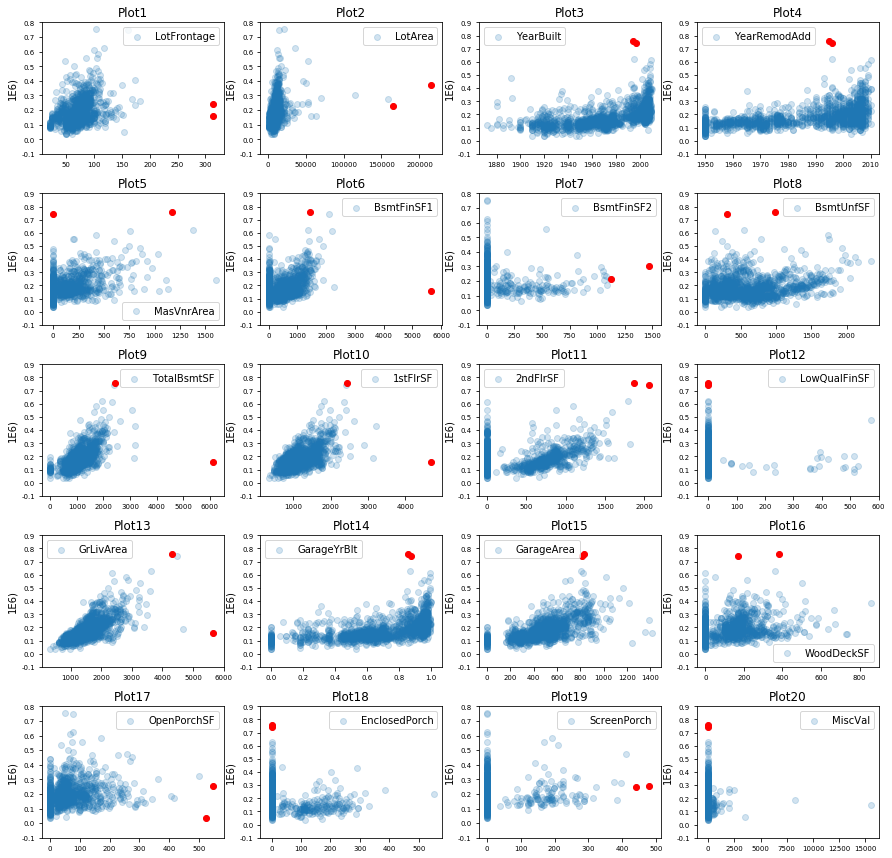

In [13]:
colList = []
count = 0
for i, col in enumerate(train.columns):
    if (i != 0) & (train[col].dtype != 'O') & (col != 'SalePrice'):
        # Only consider continous variables
        if len(train[col].value_counts()) > 20:
            colList.append(col)
            count += 1

rows = int(np.ceil(len(colList) / 4))    # 4 plots per row
f = plt.figure(figsize=(15,3*rows))

for i, col in enumerate(colList):
    #print(col)
    axi = f.add_subplot(rows, 4, i+1)
    plt.scatter(train[col], train.SalePrice, label = col, alpha = 0.2)
    df = train[[col, 'SalePrice']]
    X = df.values
    elenv = EllipticEnvelope(contamination=.001)
    pred = elenv.fit_predict(X)
    anom_index = np.where(pred==-1)
    values = X[anom_index]

    plt.scatter(values[:,0],values[:,1], color='r')
    plt.title("Plot" + str(i+1))
    axi.tick_params(axis="x", labelsize=7)
    axi.tick_params(axis="y", labelsize=7)
    locs,labels = plt.yticks()
    plt.yticks(locs, map(lambda x: "%.1f" % x, locs/1e6))
    plt.ylabel('1E6)')
    plt.legend()
    
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.3)

*Assuming a contamination of outliers in the dataset of 0.1% the above red datapoints have been suggested as outliers according to sklearn's "elliptic envelope"* <br> From the above plots it seems only appropriate to consider those in plots 1, 2, 6, 9, 10, 13, 17, 20"  

In [14]:
train_ = train.copy()
# Plot1
train_ = train_[(train_.LotFrontage < 300)]
# Plot2
train_ = train_[(train_.LotArea < 150000)]
# Plot6
train_ = train_[(train_.BsmtFinSF1 < 5000)]   
# Plot9
train_ = train_[(train_.TotalBsmtSF < 6000)]  
# Plot10
train_ = train_[(train_['1stFlrSF'] < 4000)]    
# Plot13
train_ = train_[(train_.GrLivArea < 5000)]    
# Plot17
train_ = train_[(train_.OpenPorchSF < 500)]   
# Plot20
train_ = train_[(train_.MiscVal < 15000)]

# Examine size of data with outliers removed vrs those without
print('Deleted {} points.'.format(train.shape[0] - train_.shape[0]))
train.shape, train_.shape                                      

Deleted 9 points.


((1460, 76), (1451, 76))

##### Check skewness of target variable --------------------------------------------------------------------------------------------------------------------------------------------
        - correct with log of target

In [15]:
def plotDistrib(df_):
    df = df_.copy()
    f = plt.figure(figsize=(15,4))
    label_ = 'original'
    for i in range(0, 4):
        axi = f.add_subplot(2, 2, i+1)
        if i%2 == 0:
            sns.distplot(df['SalePrice'], ax= axi)#label = label_)
        else:
            res = probplot(df['SalePrice'], plot=axi)#label = label_)
        
        plt.legend(title=label_, loc='upper left')
        if i == 1:
            label_ = 'log_transform'
            #print("Skewness: %f" % df['SalePrice'].skew())
            #print("Kurtosis: %f" % df['SalePrice'].kurt())
            df["SalePrice"] = np.log(df['SalePrice'])
            #print("Skewness: %f" % df['SalePrice'].skew())
            #print("Kurtosis: %f" % df['SalePrice'].kurt())
            
        #, labels=['Hell Yeh', 'Nah Bruh'])
            
    plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.60)

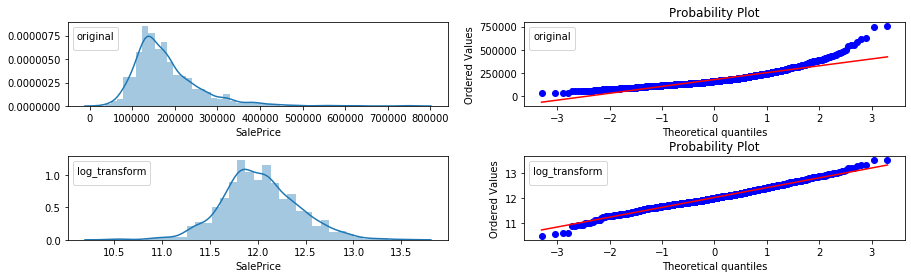

In [16]:
train = train_.copy()
plotDistrib(train_)
train['SalePrice'] = np.log(train_['SalePrice'])
train_ = train.copy()

##### Check skewness of continous features: -----------------------------------------------------------------------------------------------------------------------------------
*'If you log transform the response variable, it is required to also log transform feature variables that are skewed."* <br>
https://becominghuman.ai/how-to-deal-with-skewed-dataset-in-machine-learning-afd2928011cc

In [17]:
# Check the skew of all continuous features ('colList' defined above)
def checkSkewness(df, colList_):
    skewed_feats = df[colList_].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
    print("\nSkew in numerical features:")
    skewness = pd.DataFrame({'Skew' :skewed_feats})
    return skewness

In [18]:
skewDf = checkSkewness(train, colList)
skewDf.head()


Skew in numerical features:


,Skew
MiscVal,19.725720
LowQualFinSF,8.973279
LotArea,6.266328
BsmtFinSF2,4.274151
ScreenPorch,4.006622


*Box-Cox transformation 'boxcox1p' to attempt removal of some skewness*

In [19]:
df = train.copy()

In [20]:
train = df.copy()

In [21]:
skewDf = skewDf[abs(skewDf.Skew) > 2] ## Assume skewness level above 2 is considered
#print("There are {} relatively skewed numerical features to Box Cox transform".format(skewDf.shape[0]))

skewed_features = skewDf.index
lam = 0.15
for feat in skewed_features:
    train[feat] = boxcox1p(train[feat], lam)

# Check the skew of updated features
skewDf = checkSkewness(train, colList)
skewDf.head(5)


Skew in numerical features:


,Skew
LowQualFinSF,7.568654
MiscVal,5.576180
ScreenPorch,3.185447
BsmtFinSF2,2.629567
EnclosedPorch,2.159021


In [22]:
df = train.copy()
train_ = train.copy()

*Skewness has been reduced to more reasonable levels*

##### Build various datasets: ----------------------------------------------------------------------------------------------------------------

*Various representations of categorical features will be explored*
    - numerical encoding, binary encoding and one-hot encoding

*Categorical to numerical encoding:*

In [23]:
cat_vars = train.dtypes[train.dtypes == "object"].index
for i, var in enumerate(cat_vars):
    #print(var)
    train[var] = train[var].astype('category')
    train[var] = train[var].cat.codes

    Keep backup of original numerical-encoded train

In [24]:
train_num = train.copy()
train = train_.copy()

*Convert to Binary encoding:* 

In [25]:
# use binary encoding to encode two categorical features
enc = BinaryEncoder(cols=cat_vars.values.tolist()).fit(train)
# transform the dataset
train_bin = enc.transform(df)
print(train_bin.shape)
train_bin.head(2)

(1451, 183)


,Id,MSSubClass,MSZoning_0,MSZoning_1,MSZoning_2,MSZoning_3,LotFrontage,LotArea,Street_0,Street_1,LotShape_0,LotShape_1,LotShape_2,LandContour_0,LandContour_1,LandContour_2,Utilities_0,Utilities_1,LotConfig_0,LotConfig_1,LotConfig_2,LotConfig_3,LandSlope_0,LandSlope_1,LandSlope_2,Neighborhood_0,Neighborhood_1,Neighborhood_2,Neighborhood_3,Neighborhood_4,Neighborhood_5,Condition1_0,Condition1_1,Condition1_2,Condition1_3,Condition1_4,Condition2_0,Condition2_1,Condition2_2,Condition2_3,BldgType_0,BldgType_1,BldgType_2,BldgType_3,HouseStyle_0,HouseStyle_1,HouseStyle_2,HouseStyle_3,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle_0,RoofStyle_1,RoofStyle_2,RoofStyle_3,RoofMatl_0,RoofMatl_1,RoofMatl_2,RoofMatl_3,Exterior1st_0,Exterior1st_1,Exterior1st_2,Exterior1st_3,Exterior1st_4,Exterior2nd_0,Exterior2nd_1,Exterior2nd_2,Exterior2nd_3,Exterior2nd_4,MasVnrType_0,MasVnrType_1,MasVnrType_2,MasVnrType_3,MasVnrArea,ExterQual_0,ExterQual_1,ExterQual_2,ExterCond_0,ExterCond_1,ExterCond_2,ExterCond_3,Foundation_0,Foundation_1,Foundation_2,Foundation_3,BsmtQual_0,BsmtQual_1,BsmtQual_2,BsmtQual_3,BsmtCond_0,BsmtCond_1,BsmtCond_2,BsmtCond_3,BsmtExposure_0,BsmtExposure_1,BsmtExposure_2,BsmtExposure_3,BsmtFinType1_0,BsmtFinType1_1,BsmtFinType1_2,BsmtFinType1_3,BsmtFinSF1,BsmtFinType2_0,BsmtFinType2_1,BsmtFinType2_2,BsmtFinType2_3,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating_0,Heating_1,Heating_2,Heating_3,HeatingQC_0,HeatingQC_1,HeatingQC_2,HeatingQC_3,CentralAir_0,CentralAir_1,Electrical_0,Electrical_1,Electrical_2,Electrical_3,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual_0,KitchenQual_1,KitchenQual_2,TotRmsAbvGrd,Functional_0,Functional_1,Functional_2,Functional_3,Fireplaces,GarageType_0,GarageType_1,GarageType_2,GarageType_3,GarageYrBlt,GarageFinish_0,GarageFinish_1,GarageFinish_2,GarageCars,GarageArea,GarageQual_0,GarageQual_1,GarageQual_2,GarageQual_3,GarageCond_0,GarageCond_1,GarageCond_2,GarageCond_3,PavedDrive_0,PavedDrive_1,PavedDrive_2,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType_0,SaleType_1,SaleType_2,SaleType_3,SaleType_4,SaleCondition_0,SaleCondition_1,SaleCondition_2,SaleCondition_3,SalePrice
0,1,60,0,0,0,1,65.0,19.212182,0,1,0,0,1,0,0,1,0,1,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,7,5,2003,2003,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,1,8.059126,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,706,0,0,0,1,0.0,150,856,0,0,0,1,0,0,0,1,0,1,0,0,0,1,856,854,0.0,1710,1,0,2,1,3,1,0,0,1,8,0,0,0,1,0,0,0,0,1,0.936364,0,0,1,2,548,0,0,0,1,0,0,0,1,0,0,1,0,61,0.0,0,0.0,0,0.0,2,2008,0,0,0,0,1,0,0,0,1,12.247694
1,2,20,0,0,0,1,80.0,19.712205,0,1,0,0,1,0,0,1,0,1,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,1,0,6,8,1976,1976,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0.000000,0,1,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,1,0,978,0,0,0,1,0.0,284,1262,0,0,0,1,0,0,0,1,0,1,0,0,0,1,1262,0,0.0,1262,0,1,2,0,3,1,0,1,0,6,0,0,0,1,1,0,0,0,1,0.690909,0,0,1,2,460,0,0,0,1,0,0,0,1,0,0,1,298,0,0.0,0,0.0,0,0.0,5,2007,0,0,0,0,1,0,0,0,1,12.109011


*Convert to One-hot encoding:*

In [26]:
train_one = train_num.copy()
for i, var in enumerate(cat_vars):
    temp = pd.get_dummies(train_one[var],prefix=var, drop_first = True )
    train_one = pd.concat([train_one,temp], axis=1)
    train_one.drop(var, axis=1, inplace = True)

print(train_one.shape)
train_one.head(2)

(1451, 242)


,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice,MSZoning_1,MSZoning_2,MSZoning_3,MSZoning_4,Street_1,LotShape_1,LotShape_2,LotShape_3,LandContour_1,LandContour_2,LandContour_3,Utilities_1,LotConfig_1,LotConfig_2,LotConfig_3,LotConfig_4,LandSlope_1,LandSlope_2,Neighborhood_1,Neighborhood_2,Neighborhood_3,Neighborhood_4,Neighborhood_5,Neighborhood_6,Neighborhood_7,Neighborhood_8,Neighborhood_9,Neighborhood_10,Neighborhood_11,Neighborhood_12,Neighborhood_13,Neighborhood_14,Neighborhood_15,Neighborhood_16,Neighborhood_17,Neighborhood_18,Neighborhood_19,Neighborhood_20,Neighborhood_21,Neighborhood_22,Neighborhood_23,Neighborhood_24,Condition1_1,Condition1_2,Condition1_3,Condition1_4,Condition1_5,Condition1_6,Condition1_7,Condition1_8,Condition2_1,Condition2_2,Condition2_3,Condition2_4,Condition2_5,Condition2_6,BldgType_1,BldgType_2,BldgType_3,BldgType_4,HouseStyle_1,HouseStyle_2,HouseStyle_3,HouseStyle_4,HouseStyle_5,HouseStyle_6,HouseStyle_7,RoofStyle_1,RoofStyle_2,RoofStyle_3,RoofStyle_4,RoofStyle_5,RoofMatl_1,RoofMatl_2,RoofMatl_3,RoofMatl_4,RoofMatl_5,RoofMatl_6,Exterior1st_1,Exterior1st_2,Exterior1st_3,Exterior1st_4,Exterior1st_5,Exterior1st_6,Exterior1st_7,Exterior1st_8,Exterior1st_9,Exterior1st_10,Exterior1st_11,Exterior1st_12,Exterior1st_13,Exterior1st_14,Exterior2nd_1,Exterior2nd_2,Exterior2nd_3,Exterior2nd_4,Exterior2nd_5,Exterior2nd_6,Exterior2nd_7,Exterior2nd_8,Exterior2nd_9,Exterior2nd_10,Exterior2nd_11,Exterior2nd_12,Exterior2nd_13,Exterior2nd_14,Exterior2nd_15,MasVnrType_1,MasVnrType_2,MasVnrType_3,MasVnrType_4,ExterQual_1,ExterQual_2,ExterQual_3,ExterCond_1,ExterCond_2,ExterCond_3,ExterCond_4,Foundation_1,Foundation_2,Foundation_3,Foundation_4,Foundation_5,BsmtQual_1,BsmtQual_2,BsmtQual_3,BsmtQual_4,BsmtCond_1,BsmtCond_2,BsmtCond_3,BsmtCond_4,BsmtExposure_1,BsmtExposure_2,BsmtExposure_3,BsmtExposure_4,BsmtFinType1_1,BsmtFinType1_2,BsmtFinType1_3,BsmtFinType1_4,BsmtFinType1_5,BsmtFinType1_6,BsmtFinType2_1,BsmtFinType2_2,BsmtFinType2_3,BsmtFinType2_4,BsmtFinType2_5,BsmtFinType2_6,Heating_1,Heating_2,Heating_3,Heating_4,Heating_5,HeatingQC_1,HeatingQC_2,HeatingQC_3,HeatingQC_4,CentralAir_1,Electrical_1,Electrical_2,Electrical_3,Electrical_4,KitchenQual_1,KitchenQual_2,KitchenQual_3,Functional_1,Functional_2,Functional_3,Functional_4,Functional_5,Functional_6,GarageType_1,GarageType_2,GarageType_3,GarageType_4,GarageType_5,GarageType_6,GarageFinish_1,GarageFinish_2,GarageFinish_3,GarageQual_1,GarageQual_2,GarageQual_3,GarageQual_4,GarageQual_5,GarageCond_1,GarageCond_2,GarageCond_3,GarageCond_4,GarageCond_5,PavedDrive_1,PavedDrive_2,SaleType_1,SaleType_2,SaleType_3,SaleType_4,SaleType_5,SaleType_6,SaleType_7,SaleType_8,SaleCondition_1,SaleCondition_2,SaleCondition_3,SaleCondition_4,SaleCondition_5
0,1,60,65.0,19.212182,7,5,2003,2003,8.059126,706,0.0,150,856,856,854,0.0,1710,1,0,2,1,3,1,8,0,0.936364,2,548,0,61,0.0,0,0.0,0,0.0,2,2008,12.247694,0,0,1,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0
1,2,20,80.0,19.712205,6,8,1976,1976,0.000000,978,0.0,284,1262,1262,0,0.0,1262,0,1,2,0,3,1,6,1,0.690909,2,460,298,0,0.0,0,0.0,0,0.0,5,2007,12.109011,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0

*Scaled datasets of all types*

In [27]:
# 1. Standardised Dataset
def scaleData(df):
    mm = MinMaxScaler() #StandardScaler()
    df_ = df.copy()
    df_[df_.columns[:-1]] = mm.fit_transform(df[df.columns[:-1]])
    return df_

In [28]:
train_num_scaled = scaleData(train_num)
print(train_num.shape, train_num_scaled.shape)
train_num_scaled.SalePrice.isnull().sum()

(1451, 76) (1451, 76)


0

In [29]:
train_one_scaled = scaleData(train_one)
train_bin_scaled = scaleData(train_bin)
train_num_scaled = scaleData(train_num)

In [30]:
train_num_scaled.head(2)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,0.000000,0.235294,0.75,0.273292,0.337851,1.0,1.0,1.0,0.0,1.0,0.0,0.208333,0.250,0.333333,0.0,0.714286,0.666667,0.500,0.949275,0.883333,0.2,0.0,0.857143,0.866667,0.25,0.597109,0.666667,1.0,0.4,0.5,1.0,0.75,0.333333,0.312389,1.0,0.0,0.064212,0.266999,0.2,0.0,1.0,1.0,0.180373,0.413559,0.0,0.316905,0.333333,0.0,0.666667,0.5,0.375,0.333333,0.666667,0.500000,1.0,0.000000,0.166667,0.936364,0.666667,0.5,0.394245,1.0,1.0,1.0,0.000000,0.145933,0.0,0.0,0.0,0.0,0.0,0.090909,0.50,1.0,0.8,12.247694
1,0.000685,0.000000,0.75,0.366460,0.364526,1.0,1.0,1.0,0.0,0.5,0.0,1.000000,0.125,0.333333,0.0,0.285714,0.555556,0.875,0.753623,0.433333,0.2,0.0,0.571429,0.533333,0.50,0.000000,1.000000,1.0,0.2,0.5,1.0,0.25,0.000000,0.432743,1.0,0.0,0.121575,0.393637,0.2,0.0,1.0,1.0,0.320663,0.000000,0.0,0.213726,0.000000,0.5,0.666667,0.0,0.375,0.333333,1.000000,0.333333,1.0,0.333333,0.166667,0.690909,0.666667,0.5,0.330935,1.0,1.0,1.0,0.347725,0.000000,0.0,0.0,0.0,0.0,0.0,0.363636,0.25,1.0,0.8,12.109011


##### Visualise highest Pearson's coefficient correlations with 'SalePrice': -----------------------------------------------------------------------------------------------

In [31]:
def checkTargetVarCorrel(df):
    lstCorrelRanks = []
    for i, col in enumerate(df):
        if col != 'SalePrice':
            #print(type(df[col].values[0]), col)
            pearson_coeff = round(pearsonr(df['SalePrice'], df[col])[0], 2)
            lstCorrelRanks.append([col, pearson_coeff, df[col].dtype])
            #print(col, pearson_coeff)
    df_correl = pd.DataFrame(lstCorrelRanks, columns = ['Var', 'Value', 'DataType'])
    df_correl.sort_values(by = 'Value', ascending = False, inplace = True)
    df_correl.reset_index(drop = True, inplace = True)
    return df_correl

In [32]:
# Most positively correlated with 'SalePrice'
df_correl = checkTargetVarCorrel(train_num)
df_correl.head()

,Var,Value,DataType
0,OverallQual,0.82,int64
1,GrLivArea,0.72,int64
2,GarageCars,0.68,int64
3,GarageArea,0.66,int64
4,TotalBsmtSF,0.64,int64


In [33]:
# Most negatively correlated with 'SalePrice'
df_correl = checkTargetVarCorrel(train_num)
df_correl.sort_values(by = 'Value', ascending = True, inplace = True)
df_correl.head()

,Var,Value,DataType
74,ExterQual,-0.59,int8
73,BsmtQual,-0.58,int8
72,KitchenQual,-0.54,int8
71,GarageType,-0.50,int8
70,HeatingQC,-0.43,int8


##### Multicollinearity within datasets: ----------------------------------------------------------------------------------------------------------------

*There is certainly a real risk of multicollinearity between features within these datasets. For example 'Garage' variables alone will be highly correlated with eachother.*<br>
In order to reduce this risk, tree-based algorithms will only be used in the presence of features with multi-collinearity. Otherwise for algorithms susceptible to this problem (i.e. linear regression), preprocessing on the dataset via PCA-based feature reduction will be introduced. Algorithms with susceptibility to multicollinearity will only be subject to the PCA-reduced dataset.
*Here several approaches will be demonstrated:* <br>

1. Datasets with PCA-based feature reduction to remove multicollinearity
2. Original datasets for tree-based algorithms that do not exhibit same risks of multicollinearity
3. Tree-based algorithms will also be trialed on the PCA-datasets

#### 3. Machine Learning

- Helper Methods
        - Hyperparameter-tuning & train-test splits <br>
*Hyperparameter tuning completed via Bayesian Optimisation*        

In [34]:
#### ---------------------------------- HELPER FUNCTIONS --------------------------------------------------------------------

def testModel(df, n_splits, model, returnVal = False, printOutput = True):
    
    X = df.drop(['SalePrice'], axis = 1).values
    y = df.drop(df.columns.difference(['SalePrice']), axis = 1).values
    kf = KFold(n_splits, True, 1)
    rmsleScores = []
    
    if printOutput:
        print("RMSLE Value For Kf_i: ", end = ' ')
    for train_index, test_index in kf.split(X):
        trainX, testX = X[train_index], X[test_index]
        trainy, testy = y[train_index], y[test_index]
        model_ = clone(model)
        model_.fit(trainX,trainy)
        preds = model_.predict(testX)
        rmsleScore = rmsle(np.exp(testy), np.exp(preds))
        rmsleScores.append(rmsleScore)
        if printOutput:
            print(round(rmsleScore, 2), end = ', ')
    if printOutput:
        print ("Average RMSLE: ", round(sum(rmsleScores) / n_splits, 3))
    if returnVal:
        return round(sum(rmsleScores) / n_splits, 3)

## -----------------------------------------------------------------------------------------------------------------------

def run_train_test_split(df, estimator):
    X = df.drop(['SalePrice'], axis = 1).values
    y = df.drop(df.columns.difference(['SalePrice']), axis = 1).values
    rmsle_scorer = make_scorer(rmsle, greater_is_better=False)
    cval = cross_val_score(estimator, X, y, scoring=rmsle_scorer, cv=4, n_jobs = -1)
    return cval.mean()

#### ---------------------------------- LOSS FUNCTION --------------------------------------------------------------------
def rmsle(ytrue, ypred):
    try:
        return np.sqrt(mean_squared_log_error(ytrue, ypred))
    except ValueError:
        return np.sqrt(mean_squared_log_error(ytrue + 100, ypred + 100)) # prevent negative log-values   
    

#### ---------------------------------- OPTIMISERS --------------------------------------------------------------------

# -------   RandomForest optimiser   -------
def optimiseRF(data, pbounds_):
    
    def train_bayes_opt_rforest(max_depth, min_impurity_decrease, n_estimators):
        params_ = {
            'max_depth': int(round(max_depth)),
            'min_impurity_decrease': float(min_impurity_decrease),
            'n_estimators': int(round(n_estimators))
        }
        mdl = RandomForestRegressor(**params_)
        return run_train_test_split(data, mdl)
    
    optimizer = BayesianOptimization(f=train_bayes_opt_rforest, pbounds = pbounds_, random_state=1)
    optimizer.maximize(init_points=10, n_iter=30)

    print("Final result:", optimizer.max)
    max_params = optimizer.max
    max_params['params']['max_depth'] = int(round(max_params['params']['max_depth']))
    max_params['params']['n_estimators'] = int(round(max_params['params']['n_estimators']))
    return max_params

## -----------------------------------------------------------------------------------------------------------------------

# -------   XGBoost optimiser   -------
def optimiseXGBoost(data, pbounds_):
    
    def train_bayes_opt_XGBoost(max_depth, gamma, learning_rate, n_estimators):
        params_ = {       
        'max_depth': int(round(max_depth)),
        'gamma': gamma,
        'learning_rate':learning_rate,
        'n_estimators':int(round(n_estimators))
        }
        mdl = xgb.XGBRegressor(**params_, silent = True)
        return run_train_test_split(data, mdl)
    
    optimizer = BayesianOptimization(f=train_bayes_opt_XGBoost, pbounds = pbounds_, random_state=1)
    optimizer.maximize(init_points=10, n_iter=30)

    print("Final result:", optimizer.max)
    max_params = optimizer.max
    max_params['params']['max_depth'] = int(round(max_params['params']['max_depth']))
    max_params['params']['n_estimators'] = int(round(max_params['params']['n_estimators']))
    return max_params

## -----------------------------------------------------------------------------------------------------------------------

# -------   LightGBM optimiser   -------
def optimiseLightGBM(data, pbounds_):
    
    def train_bayes_opt_LightGBM(max_depth, gamma, learning_rate, n_estimators):
        params_ = {       
        'max_depth': int(round(max_depth)),
        'gamma': gamma,
        'learning_rate':learning_rate,
        'n_estimators':int(round(n_estimators))
        }
        mdl = LGBMRegressor(**params_)
        return run_train_test_split(data, mdl)
    
    optimizer = BayesianOptimization(f=train_bayes_opt_LightGBM, pbounds = pbounds_, random_state=1)
    optimizer.maximize(init_points=10, n_iter=30)

    print("Final result:", optimizer.max)
    max_params = optimizer.max
    max_params['params']['max_depth'] = int(round(max_params['params']['max_depth']))
    max_params['params']['n_estimators'] = int(round(max_params['params']['n_estimators'])) 
    return max_params

## -----------------------------------------------------------------------------------------------------------------------

# -------   GradientBoost optimiser   -------
def optimiseGradBoost(data, pbounds_):
    
    def train_bayes_opt_gradboost(max_depth, min_impurity_decrease, learning_rate, n_estimators):
        params_ = {       
        'max_depth': int(round(max_depth)),
        'min_impurity_decrease': min_impurity_decrease,
        'learning_rate':learning_rate,
        'n_estimators':int(round(n_estimators))
        }
        mdl = GradientBoostingRegressor(**params_)
        return run_train_test_split(data, mdl)
    
    optimizer = BayesianOptimization(f=train_bayes_opt_gradboost, pbounds = pbounds_, random_state=1)
    optimizer.maximize(init_points=10, n_iter=30)

    print("Final result:", optimizer.max)
    max_params = optimizer.max
    max_params['params']['max_depth'] = int(round(max_params['params']['max_depth']))
    max_params['params']['n_estimators'] = int(round(max_params['params']['n_estimators'])) 
    return max_params

## -----------------------------------------------------------------------------------------------------------------------

# -------   kNN optimiser   -------
def optimiseKNN(data, pbounds_):
    
    def train_bayes_opt_kNN(n_neighbors, leaf_size, p):
        params_ = {       
        'n_neighbors': int(round(n_neighbors)),
        'leaf_size':int(round(leaf_size)),
        'p': int(round(p))
        }
        mdl = KNeighborsRegressor(**params_)
        return run_train_test_split(data, mdl)
    
    optimizer = BayesianOptimization(f=train_bayes_opt_kNN, pbounds = pbounds_, random_state=1)
    optimizer.maximize(init_points=10, n_iter=30)

    print("Final result:", optimizer.max)
    max_params = optimizer.max
    max_params['params']['n_neighbors'] = int(round(max_params['params']['n_neighbors']))
    max_params['params']['leaf_size'] = int(round(max_params['params']['leaf_size'])) 
    max_params['params']['p'] = int(round(max_params['params']['p'])) 
    return max_params

## -----------------------------------------------------------------------------------------------------------------------

# -------   SVR optimiser   -------
def optimiseSVR(data, pbounds_):
    
    def train_bayes_opt_SVR(C, gamma, epsilon): #kernel, 
        params_ = {       
        #'kernel': kernel,
        'C': C,
        'gamma': gamma,
        'epsilon': epsilon
        }
        mdl = SVR(**params_)
        return run_train_test_split(data, mdl)
    
    optimizer = BayesianOptimization(f=train_bayes_opt_SVR, pbounds = pbounds_, random_state=1)
    optimizer.maximize(init_points=10, n_iter=30)

    print("Final result:", optimizer.max)
    max_params = optimizer.max

    return max_params

## -----------------------------------------------------------------------------------------------------------------------

# -------   MLP optimiser   -------
def optimiseMLP(data, pbounds_):
    
    def train_bayes_opt_MLP(learning_rate_init, hidden_layer_sizes, alpha): #kernel, 
        params_ = {       
        #'kernel': kernel,
        'learning_rate_init': learning_rate_init,
        'hidden_layer_sizes': int(round(hidden_layer_sizes)),
        'alpha': alpha
        }
        mdl = MLPRegressor(**params_)
        return run_train_test_split(data, mdl)
    
    optimizer = BayesianOptimization(f=train_bayes_opt_MLP, pbounds = pbounds_, random_state=1)
    optimizer.maximize(init_points=10, n_iter=30)

    print("Final result:", optimizer.max)
    max_params = optimizer.max
    max_params['params']['hidden_layer_sizes'] = int(round(max_params['params']['hidden_layer_sizes']))

    return max_params


## -----------------------------------------------------------------------------------------------------------------------

# -------   Lasso optimiser   -------
def optimiseLasso(data, pbounds_):
    
    def train_bayes_opt_Lasso(alpha): #kernel, 
        params_ = {       
        #'kernel': kernel,
        'alpha': alpha
        }
        mdl = Lasso(**params_)
        return run_train_test_split(data, mdl)
    
    optimizer = BayesianOptimization(f=train_bayes_opt_Lasso, pbounds = pbounds_, random_state=1)
    optimizer.maximize(init_points=10, n_iter=30)

    print("Final result:", optimizer.max)
    max_params = optimizer.max

    return max_params

## -----------------------------------------------------------------------------------------------------------------------

# -------   Ridge optimiser   -------
def optimiseLasso(data, pbounds_):
    
    def train_bayes_opt_Lasso(alpha): #kernel, 
        params_ = {       
        #'kernel': kernel,
        'alpha': alpha
        }
        mdl = Lasso(**params_)
        return run_train_test_split(data, mdl)
    
    optimizer = BayesianOptimization(f=train_bayes_opt_Lasso, pbounds = pbounds_, random_state=1)
    optimizer.maximize(init_points=10, n_iter=30)

    print("Final result:", optimizer.max)
    max_params = optimizer.max

    return max_params

## -----------------------------------------------------------------------------------------------------------------------

# -------   Ridge optimiser   -------
def optimiseRidge(data, pbounds_):
    
    def train_bayes_opt_Ridge(alpha): #kernel, 
        params_ = {       
        #'kernel': kernel,
        'alpha': alpha
        }
        mdl = Ridge(**params_)
        return run_train_test_split(data, mdl)
    
    optimizer = BayesianOptimization(f=train_bayes_opt_Ridge, pbounds = pbounds_, random_state=1)
    optimizer.maximize(init_points=10, n_iter=30)

    print("Final result:", optimizer.max)
    max_params = optimizer.max

    return max_params

##### Numerical features datasets: ----------------------------------------------------------------------------------------------------------------

- **Without PCA: Only tree-based models**

i.a. Try Random Forest without scaling (Hyperparameter tuning)

In [192]:
bounds_ = {'n_estimators':(50, 250),
              'min_impurity_decrease':(0.0,0.01),
              'max_depth':(5,100)
             }

max_params = optimiseRF(train_num, bounds_)                                      
rfModel = RandomForestRegressor(**max_params['params'])
testModel(df = train_num, n_splits = 10, model = rfModel)

|   iter    |  target   | max_depth | min_im... | n_esti... |
-------------------------------------------------------------
|  1        | -0.01719  |  44.62    |  0.007203 |  50.02    |
|  2        | -0.01364  |  33.72    |  0.001468 |  68.47    |
|  3        | -0.0155   |  22.69    |  0.003456 |  129.4    |
|  4        | -0.01596  |  56.19    |  0.004192 |  187.0    |
|  5        | -0.01753  |  24.42    |  0.008781 |  55.48    |
|  6        | -0.01588  |  68.69    |  0.004173 |  161.7    |
|  7        | -0.01412  |  18.34    |  0.001981 |  210.1    |
|  8        | -0.01513  |  96.98    |  0.003134 |  188.5    |
|  9        | -0.01758  |  88.26    |  0.008946 |  67.01    |
|  10       | -0.01386  |  8.71     |  0.001698 |  225.6    |
|  11       | -0.01356  |  5.241    |  0.001428 |  249.6    |
|  12       | -0.01311  |  5.322    |  0.001079 |  249.9    |
|  13       | -0.01505  |  5.277    |  0.003086 |  249.4    |
|  14       | -0.01271  |  5.238    |  0.000678 |  249.6    |
|  15   

i.b. Try Random Forest with scaling (Hyperparameter tuning)

In [155]:
bounds_ = {'n_estimators':(50, 250),
              'min_impurity_decrease':(0.0,0.01),
              'max_depth':(1,100)
             }
max_params = optimiseRF(train_num_scaled, bounds_)
rfModel = RandomForestRegressor(**max_params['params'])
testModel(df = train_num_scaled, n_splits = 10, model = rfModel)

|   iter    |  target   | max_depth | min_im... | n_esti... |
-------------------------------------------------------------
|  1        | -0.01722  |  42.29    |  0.007203 |  50.02    |
|  2        | -0.01364  |  30.93    |  0.001468 |  68.47    |
|  3        | -0.01539  |  19.44    |  0.003456 |  129.4    |
|  4        | -0.01594  |  54.34    |  0.004192 |  187.0    |
|  5        | -0.01764  |  21.24    |  0.008781 |  55.48    |
|  6        | -0.01599  |  67.38    |  0.004173 |  161.7    |
|  7        | -0.01412  |  14.9     |  0.001981 |  210.1    |
|  8        | -0.01516  |  96.86    |  0.003134 |  188.5    |
|  9        | -0.01766  |  87.76    |  0.008946 |  67.01    |
|  10       | -0.01384  |  4.866    |  0.001698 |  225.6    |
|  11       | -0.02232  |  1.251    |  0.001428 |  249.6    |
|  12       | -0.01572  |  99.85    |  0.003951 |  249.7    |
|  13       | -0.02232  |  1.045    |  0.003729 |  176.6    |
|  14       | -0.01466  |  53.03    |  0.002615 |  242.7    |
|  15   

ii.a. Try XGBoost without scaling (Hyperparameter tuning)

In [156]:
bounds_ = {'n_estimators':(50, 1000),
              'learning_rate':(0.1,0.8),
              'max_depth':(1,10),
               'gamma':(0,1),
             }

max_params = optimiseXGBoost(train_num, bounds_)
xgbModel = xgb.XGBRegressor(**max_params['params'])
testModel(df = train_num, n_splits = 10, model = xgbModel)

|   iter    |  target   |   gamma   | learni... | max_depth | n_esti... |
-------------------------------------------------------------------------
|  1        | -0.01267  |  0.417    |  0.6042   |  1.001    |  337.2    |
|  2        | -0.01076  |  0.1468   |  0.1646   |  2.676    |  378.3    |
|  3        | -0.01246  |  0.3968   |  0.4772   |  4.773    |  701.0    |
|  4        | -0.01164  |  0.2045   |  0.7147   |  1.246    |  686.9    |
|  5        | -0.01232  |  0.4173   |  0.4911   |  2.263    |  238.2    |
|  6        | -0.01397  |  0.8007   |  0.7778   |  3.821    |  707.7    |
|  7        | -0.01384  |  0.8764   |  0.7262   |  1.765    |  87.1     |
|  8        | -0.01165  |  0.1698   |  0.7147   |  1.885    |  450.1    |
|  9        | -0.01298  |  0.9579   |  0.4732   |  7.227    |  349.7    |
|  10       | -0.01327  |  0.6865   |  0.6842   |  1.165    |  762.6    |
|  11       | -0.01348  |  0.7978   |  0.7001   |  9.59     |  1e+03    |
|  12       | -0.0113   |  0.315    | 

ii.b. Try XGBoost with scaling (Hyperparameter tuning)

In [157]:
bounds_ = {'n_estimators':(50, 1000),
              'learning_rate':(0.1,0.8),
              'max_depth':(1,10),
               'gamma':(0,1),
             }

max_params = optimiseXGBoost(train_num_scaled, bounds_)
xgbModel = xgb.XGBRegressor(**max_params['params'])
testModel(df = train_num_scaled, n_splits = 10, model = xgbModel)

|   iter    |  target   |   gamma   | learni... | max_depth | n_esti... |
-------------------------------------------------------------------------
|  1        | -0.01267  |  0.417    |  0.6042   |  1.001    |  337.2    |
|  2        | -0.01076  |  0.1468   |  0.1646   |  2.676    |  378.3    |
|  3        | -0.01246  |  0.3968   |  0.4772   |  4.773    |  701.0    |
|  4        | -0.01164  |  0.2045   |  0.7147   |  1.246    |  686.9    |
|  5        | -0.01232  |  0.4173   |  0.4911   |  2.263    |  238.2    |
|  6        | -0.01397  |  0.8007   |  0.7778   |  3.821    |  707.7    |
|  7        | -0.01384  |  0.8764   |  0.7262   |  1.765    |  87.1     |
|  8        | -0.01165  |  0.1698   |  0.7147   |  1.885    |  450.1    |
|  9        | -0.01298  |  0.9579   |  0.4732   |  7.227    |  349.7    |
|  10       | -0.01327  |  0.6865   |  0.6842   |  1.165    |  762.6    |
|  11       | -0.01201  |  0.8972   |  0.2383   |  9.827    |  999.5    |
|  12       | -0.01183  |  0.6016   | 

iii.a. Try LightGBM without scaling (Hyperparameter tuning)

In [158]:
bounds_ = {
        'gamma': (0,1),
        'max_depth': (1, 10),
        'learning_rate': (0.1, 0.8),
        'n_estimators':(50,1000),
        }
max_params = optimiseLightGBM(train_num, bounds_)
lgbmMod = LGBMRegressor(**max_params['params'])
newVal = testModel(df = train_num, n_splits = 10, model = lgbmMod)

|   iter    |  target   |   gamma   | learni... | max_depth | n_esti... |
-------------------------------------------------------------------------
|  1        | -0.009962 |  0.417    |  0.6042   |  1.001    |  337.2    |
|  2        | -0.01001  |  0.1468   |  0.1646   |  2.676    |  378.3    |
|  3        | -0.0118   |  0.3968   |  0.4772   |  4.773    |  701.0    |
|  4        | -0.01004  |  0.2045   |  0.7147   |  1.246    |  686.9    |
|  5        | -0.01061  |  0.4173   |  0.4911   |  2.263    |  238.2    |
|  6        | -0.01326  |  0.8007   |  0.7778   |  3.821    |  707.7    |
|  7        | -0.01097  |  0.8764   |  0.7262   |  1.765    |  87.1     |
|  8        | -0.01122  |  0.1698   |  0.7147   |  1.885    |  450.1    |
|  9        | -0.01141  |  0.9579   |  0.4732   |  7.227    |  349.7    |
|  10       | -0.01003  |  0.6865   |  0.6842   |  1.165    |  762.6    |
|  11       | -0.01089  |  0.2115   |  0.3861   |  9.983    |  50.25    |
|  12       | -0.0132   |  0.7043   | 

**BEST RESULT** = 0.122

iii.b. Try LightGBM with scaling (Hyperparameter tuning)

In [159]:
bounds_ = {
        'gamma': (0,1),
        'max_depth': (1, 10),
        'learning_rate': (0.1, 0.8),
        'n_estimators':(50,1000),
        }
max_params = optimiseLightGBM(train_num_scaled.copy(), bounds_)
lgbmMod = LGBMRegressor(**max_params['params'])
newVal = testModel(df = train_num_scaled, n_splits = 10, model = lgbmMod)

|   iter    |  target   |   gamma   | learni... | max_depth | n_esti... |
-------------------------------------------------------------------------
|  1        | -0.009992 |  0.417    |  0.6042   |  1.001    |  337.2    |
|  2        | -0.01004  |  0.1468   |  0.1646   |  2.676    |  378.3    |
|  3        | -0.01182  |  0.3968   |  0.4772   |  4.773    |  701.0    |
|  4        | -0.01004  |  0.2045   |  0.7147   |  1.246    |  686.9    |
|  5        | -0.0105   |  0.4173   |  0.4911   |  2.263    |  238.2    |
|  6        | -0.01336  |  0.8007   |  0.7778   |  3.821    |  707.7    |
|  7        | -0.01098  |  0.8764   |  0.7262   |  1.765    |  87.1     |
|  8        | -0.01158  |  0.1698   |  0.7147   |  1.885    |  450.1    |
|  9        | -0.01154  |  0.9579   |  0.4732   |  7.227    |  349.7    |
|  10       | -0.01006  |  0.6865   |  0.6842   |  1.165    |  762.6    |
|  11       | -0.01137  |  0.5685   |  0.7994   |  1.274    |  50.09    |
|  12       | -0.01205  |  0.605    | 

*A very good score with the lightGBM*

iv.a. Try Gradient Boosting Regressor without scaling (Hyperparameter tuning)

In [160]:
bounds_ = {
        'min_impurity_decrease': (0.0,0.01),
        'max_depth': (1, 10),
        'learning_rate': (0.1, 0.8),
        'n_estimators':(50,1000),
        }
max_params = optimiseGradBoost(train_num, bounds_)
gbModel = GradientBoostingRegressor(**max_params['params'])
newVal = testModel(df = train_num, n_splits = 10, model = gbModel)

|   iter    |  target   | learni... | max_depth | min_im... | n_esti... |
-------------------------------------------------------------------------
|  1        | -0.0116   |  0.3919   |  7.483    |  1.144e-0 |  337.2    |
|  2        | -0.01001  |  0.2027   |  1.831    |  0.001863 |  378.3    |
|  3        | -0.01117  |  0.3777   |  5.849    |  0.004192 |  701.0    |
|  4        | -0.01189  |  0.2431   |  8.903    |  0.000273 |  686.9    |
|  5        | -0.01108  |  0.3921   |  6.028    |  0.001404 |  238.2    |
|  6        | -0.01347  |  0.6605   |  9.714    |  0.003134 |  707.7    |
|  7        | -0.01374  |  0.7135   |  9.051    |  0.000850 |  87.1     |
|  8        | -0.01172  |  0.2189   |  8.903    |  0.000983 |  450.1    |
|  9        | -0.01408  |  0.7705   |  5.798    |  0.006919 |  349.7    |
|  10       | -0.01247  |  0.5806   |  8.512    |  0.000182 |  762.6    |
|  11       | -0.01     |  0.6701   |  1.155    |  0.00111  |  999.8    |
|  12       | -0.009874 |  0.4047   | 

iv.b. Try Gradient Boosting Regressor with scaling (Hyperparameter tuning)

In [161]:
bounds_ = {
        'min_impurity_decrease': (0.0,0.01),
        'max_depth': (1, 10),
        'learning_rate': (0.1, 0.8),
        'n_estimators':(50,1000),
        }
max_params = optimiseGradBoost(train_num_scaled, bounds_)
gbModel = GradientBoostingRegressor(**max_params['params'])
newVal = testModel(df = train_num_scaled, n_splits = 10, model = gbModel)

|   iter    |  target   | learni... | max_depth | min_im... | n_esti... |
-------------------------------------------------------------------------
|  1        | -0.01155  |  0.3919   |  7.483    |  1.144e-0 |  337.2    |
|  2        | -0.01003  |  0.2027   |  1.831    |  0.001863 |  378.3    |
|  3        | -0.01117  |  0.3777   |  5.849    |  0.004192 |  701.0    |
|  4        | -0.0119   |  0.2431   |  8.903    |  0.000273 |  686.9    |
|  5        | -0.01123  |  0.3921   |  6.028    |  0.001404 |  238.2    |
|  6        | -0.01308  |  0.6605   |  9.714    |  0.003134 |  707.7    |
|  7        | -0.01326  |  0.7135   |  9.051    |  0.000850 |  87.1     |
|  8        | -0.01157  |  0.2189   |  8.903    |  0.000983 |  450.1    |
|  9        | -0.01383  |  0.7705   |  5.798    |  0.006919 |  349.7    |
|  10       | -0.01264  |  0.5806   |  8.512    |  0.000182 |  762.6    |
|  11       | -0.01013  |  0.6701   |  1.155    |  0.00111  |  999.8    |
|  12       | -0.009963 |  0.4047   | 

*Gradient Boosting was also quite good*

- **With PCA: Variety of models**

In [35]:
def convertToPCA(df, nComponents):
    pca = PCA(n_components=nComponents)
    pcaColList = [("PC" + str(x)) for x in range(nComponents)]
    pcaX = pca.fit_transform(df[df.columns[:-1]])
    df_PCA = pd.DataFrame(pcaX, columns=pcaColList)
    df_PCA['SalePrice'] = df.SalePrice.values
    return df_PCA

*Do a test to confirm ideal number of components for machine-learning*

In [162]:
result = []
scaled_result = []
for nComponents in range(1, 50):
    print("{} = {}".format('number of Components: ', nComponents))
    df_PCA_num = convertToPCA(train_num, nComponents)
    df_PCA_num_scaled = convertToPCA(train_num_scaled, nComponents)
    
    # Presaved LGBMRegressor max_params:
    max_params['params'] = {'gamma': 0.0678702096992233, 'learning_rate': 0.7431734584734991, 'max_depth': 10, 'n_estimators': 52}
    lgbmMod = LGBMRegressor(**max_params['params'])
    newVal = testModel(df = df_PCA_num, n_splits = 10, model = lgbmMod, returnVal = True)
    result.append(newVal)
    lgbmMod = LGBMRegressor(**max_params['params'])
    newVal = testModel(df = df_PCA_num_scaled, n_splits = 10, model = lgbmMod, returnVal = True)
    scaled_result.append(newVal)

number of Components:  = 1
RMSLE Value For Kf_i:  0.23, 0.24, 0.23, 0.21, 0.24, 0.22, 0.24, 0.26, 0.26, 0.22, Average RMSLE:  0.235
RMSLE Value For Kf_i:  0.24, 0.22, 0.21, 0.23, 0.21, 0.25, 0.23, 0.23, 0.25, 0.21, Average RMSLE:  0.23
number of Components:  = 2
RMSLE Value For Kf_i:  0.22, 0.24, 0.21, 0.22, 0.24, 0.2, 0.24, 0.27, 0.25, 0.24, Average RMSLE:  0.234
RMSLE Value For Kf_i:  0.25, 0.25, 0.22, 0.24, 0.25, 0.27, 0.25, 0.25, 0.26, 0.24, Average RMSLE:  0.249
number of Components:  = 3
RMSLE Value For Kf_i:  0.21, 0.22, 0.22, 0.22, 0.22, 0.2, 0.24, 0.27, 0.25, 0.24, Average RMSLE:  0.231
RMSLE Value For Kf_i:  0.24, 0.23, 0.23, 0.23, 0.26, 0.25, 0.26, 0.26, 0.25, 0.23, Average RMSLE:  0.246
number of Components:  = 4
RMSLE Value For Kf_i:  0.23, 0.24, 0.23, 0.22, 0.26, 0.22, 0.24, 0.28, 0.26, 0.25, Average RMSLE:  0.243
RMSLE Value For Kf_i:  0.24, 0.24, 0.25, 0.24, 0.27, 0.25, 0.26, 0.26, 0.25, 0.22, Average RMSLE:  0.246
number of Components:  = 5
RMSLE Value For Kf_i:  0.23,

RMSLE Value For Kf_i:  0.21, 0.18, 0.17, 0.17, 0.18, 0.21, 0.17, 0.21, 0.21, 0.19, Average RMSLE:  0.189
RMSLE Value For Kf_i:  0.21, 0.2, 0.19, 0.19, 0.2, 0.21, 0.21, 0.22, 0.25, 0.17, Average RMSLE:  0.206
number of Components:  = 37
RMSLE Value For Kf_i:  0.2, 0.17, 0.16, 0.17, 0.18, 0.2, 0.17, 0.21, 0.21, 0.2, Average RMSLE:  0.187
RMSLE Value For Kf_i:  0.22, 0.2, 0.21, 0.17, 0.22, 0.22, 0.2, 0.24, 0.23, 0.19, Average RMSLE:  0.209
number of Components:  = 38
RMSLE Value For Kf_i:  0.2, 0.18, 0.17, 0.16, 0.18, 0.2, 0.17, 0.21, 0.21, 0.19, Average RMSLE:  0.188
RMSLE Value For Kf_i:  0.22, 0.21, 0.17, 0.17, 0.19, 0.21, 0.19, 0.24, 0.22, 0.19, Average RMSLE:  0.201
number of Components:  = 39
RMSLE Value For Kf_i:  0.21, 0.19, 0.16, 0.18, 0.17, 0.22, 0.17, 0.2, 0.21, 0.18, Average RMSLE:  0.188
RMSLE Value For Kf_i:  0.22, 0.2, 0.19, 0.19, 0.2, 0.2, 0.2, 0.24, 0.23, 0.16, Average RMSLE:  0.203
number of Components:  = 40
RMSLE Value For Kf_i:  0.2, 0.18, 0.16, 0.18, 0.2, 0.22, 0.17,

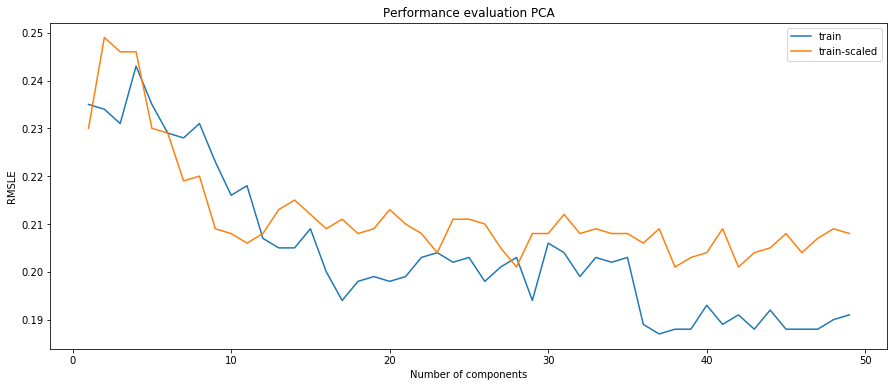

In [163]:
f, axs = plt.subplots(1, 1, figsize=(15,6))
axs.plot(range(1, len(result)+1), result, label = 'train')
axs.plot(range(1, len(scaled_result)+1), scaled_result, label = 'train-scaled')
plt.legend()
_ = axs.set(xlabel="Number of components", ylabel='RMSLE', title='Performance evaluation PCA')

*Try one set of hyperparameter tuning with PCA:* (Best performance was with 37 components) <br>
        - Scaled dataset was only better between 7-12 components
        - Decision-tree algorithms don't appear to particularly do better with scaled datasets:
        - Scaled datasets will however be applied to linear, lasso & ridge-regression, SVM, kNN, Multi-layer perceptron       

i.a PCA: Random Forest without scaling (Hyperparameter tuning)

In [167]:
df_PCA_num = convertToPCA(train_num, 37)
bounds_ = {'n_estimators':(50, 250),
              'min_impurity_decrease':(0.0,0.01),
              'max_depth':(5,100)
             }

max_params = optimiseRF(df_PCA_num, bounds_)                                      
rfModel = RandomForestRegressor(**max_params['params'])
testModel(df = df_PCA_num, n_splits = 10, model = rfModel)

|   iter    |  target   | max_depth | min_im... | n_esti... |
-------------------------------------------------------------
|  1        | -0.01794  |  44.62    |  0.007203 |  50.02    |
|  2        | -0.01507  |  33.72    |  0.001468 |  68.47    |
|  3        | -0.01646  |  22.69    |  0.003456 |  129.4    |
|  4        | -0.01685  |  56.19    |  0.004192 |  187.0    |
|  5        | -0.01809  |  24.42    |  0.008781 |  55.48    |
|  6        | -0.01689  |  68.69    |  0.004173 |  161.7    |
|  7        | -0.01553  |  18.34    |  0.001981 |  210.1    |
|  8        | -0.01629  |  96.98    |  0.003134 |  188.5    |
|  9        | -0.0182   |  88.26    |  0.008946 |  67.01    |
|  10       | -0.0153   |  8.71     |  0.001698 |  225.6    |
|  11       | -0.01501  |  5.241    |  0.001428 |  249.6    |
|  12       | -0.01463  |  5.322    |  0.001079 |  249.9    |
|  13       | -0.01626  |  5.277    |  0.003086 |  249.4    |
|  14       | -0.01442  |  99.83    |  0.001003 |  249.7    |
|  15   

ii.b PCA: Random Forest with scaling (Hyperparameter tuning)

In [168]:
df_PCA_num = convertToPCA(train_num_scaled, 37)
bounds_ = {'n_estimators':(50, 250),
              'min_impurity_decrease':(0.0,0.01),
              'max_depth':(5,100)
             }

max_params = optimiseRF(df_PCA_num, bounds_)                                      
rfModel = RandomForestRegressor(**max_params['params'])
testModel(df = df_PCA_num, n_splits = 10, model = rfModel)

|   iter    |  target   | max_depth | min_im... | n_esti... |
-------------------------------------------------------------
|  1        | -0.01785  |  44.62    |  0.007203 |  50.02    |
|  2        | -0.01603  |  33.72    |  0.001468 |  68.47    |
|  3        | -0.01737  |  22.69    |  0.003456 |  129.4    |
|  4        | -0.01761  |  56.19    |  0.004192 |  187.0    |
|  5        | -0.01794  |  24.42    |  0.008781 |  55.48    |
|  6        | -0.01759  |  68.69    |  0.004173 |  161.7    |
|  7        | -0.01648  |  18.34    |  0.001981 |  210.1    |
|  8        | -0.01723  |  96.98    |  0.003134 |  188.5    |
|  9        | -0.01791  |  88.26    |  0.008946 |  67.01    |
|  10       | -0.0162   |  8.71     |  0.001698 |  225.6    |
|  11       | -0.01594  |  5.241    |  0.001428 |  249.6    |
|  12       | -0.01555  |  5.322    |  0.001079 |  249.9    |
|  13       | -0.01723  |  5.277    |  0.003086 |  249.4    |
|  14       | -0.01546  |  99.83    |  0.001003 |  249.7    |
|  15   

ii. PCA: Try XGBoost without scaling (Hyperparameter tuning)

In [169]:
df_PCA_num = convertToPCA(train_num, 37)
bounds_ = {'n_estimators':(50, 1000),
              'learning_rate':(0.1,0.8),
              'max_depth':(1,10),
               'gamma':(0,1),
             }

max_params = optimiseXGBoost(df_PCA_num, bounds_)
xgbModel = xgb.XGBRegressor(**max_params['params'])
testModel(df = df_PCA_num, n_splits = 10, model = xgbModel)

|   iter    |  target   |   gamma   | learni... | max_depth | n_esti... |
-------------------------------------------------------------------------
|  1        | -0.01359  |  0.417    |  0.6042   |  1.001    |  337.2    |
|  2        | -0.01225  |  0.1468   |  0.1646   |  2.676    |  378.3    |
|  3        | -0.01405  |  0.3968   |  0.4772   |  4.773    |  701.0    |
|  4        | -0.01345  |  0.2045   |  0.7147   |  1.246    |  686.9    |
|  5        | -0.01368  |  0.4173   |  0.4911   |  2.263    |  238.2    |
|  6        | -0.01498  |  0.8007   |  0.7778   |  3.821    |  707.7    |
|  7        | -0.0144   |  0.8764   |  0.7262   |  1.765    |  87.1     |
|  8        | -0.01343  |  0.1698   |  0.7147   |  1.885    |  450.1    |
|  9        | -0.01465  |  0.9579   |  0.4732   |  7.227    |  349.7    |
|  10       | -0.01432  |  0.6865   |  0.6842   |  1.165    |  762.6    |
|  11       | -0.01359  |  0.2115   |  0.3861   |  9.983    |  50.25    |
|  12       | -0.01629  |  0.7043   | 

iib. Try XGBoost with scaling (Hyperparameter tuning)

In [170]:
df_PCA_num = convertToPCA(train_num_scaled, 37)
bounds_ = {'n_estimators':(50, 1000),
              'learning_rate':(0.1,0.8),
              'max_depth':(1,10),
               'gamma':(0,1),
             }

max_params = optimiseXGBoost(df_PCA_num, bounds_)
xgbModel = xgb.XGBRegressor(**max_params['params'])
testModel(df = df_PCA_num, n_splits = 10, model = xgbModel)

|   iter    |  target   |   gamma   | learni... | max_depth | n_esti... |
-------------------------------------------------------------------------
|  1        | -0.0146   |  0.417    |  0.6042   |  1.001    |  337.2    |
|  2        | -0.01339  |  0.1468   |  0.1646   |  2.676    |  378.3    |
|  3        | -0.0158   |  0.3968   |  0.4772   |  4.773    |  701.0    |
|  4        | -0.01429  |  0.2045   |  0.7147   |  1.246    |  686.9    |
|  5        | -0.01447  |  0.4173   |  0.4911   |  2.263    |  238.2    |
|  6        | -0.01585  |  0.8007   |  0.7778   |  3.821    |  707.7    |
|  7        | -0.01568  |  0.8764   |  0.7262   |  1.765    |  87.1     |
|  8        | -0.01461  |  0.1698   |  0.7147   |  1.885    |  450.1    |
|  9        | -0.01535  |  0.9579   |  0.4732   |  7.227    |  349.7    |
|  10       | -0.01532  |  0.6865   |  0.6842   |  1.165    |  762.6    |
|  11       | -0.01454  |  0.2115   |  0.3861   |  9.983    |  50.25    |
|  12       | -0.01683  |  0.7043   | 

iii. Try LightGBM without scaling (Hyperparameter tuning)

In [171]:
df_PCA_num = convertToPCA(train_num, 37)
bounds_ = {
        'gamma': (0,1),
        'max_depth': (1, 10),
        'learning_rate': (0.1, 0.8),
        'n_estimators':(50,1000),
        }
max_params = optimiseLightGBM(df_PCA_num, bounds_)
lgbmMod = LGBMRegressor(**max_params['params'])
newVal = testModel(df = df_PCA_num, n_splits = 10, model = lgbmMod)

|   iter    |  target   |   gamma   | learni... | max_depth | n_esti... |
-------------------------------------------------------------------------
|  1        | -0.01183  |  0.417    |  0.6042   |  1.001    |  337.2    |
|  2        | -0.01172  |  0.1468   |  0.1646   |  2.676    |  378.3    |
|  3        | -0.01327  |  0.3968   |  0.4772   |  4.773    |  701.0    |
|  4        | -0.01222  |  0.2045   |  0.7147   |  1.246    |  686.9    |
|  5        | -0.01269  |  0.4173   |  0.4911   |  2.263    |  238.2    |
|  6        | -0.01528  |  0.8007   |  0.7778   |  3.821    |  707.7    |
|  7        | -0.0134   |  0.8764   |  0.7262   |  1.765    |  87.1     |
|  8        | -0.01368  |  0.1698   |  0.7147   |  1.885    |  450.1    |
|  9        | -0.01316  |  0.9579   |  0.4732   |  7.227    |  349.7    |
|  10       | -0.01236  |  0.6865   |  0.6842   |  1.165    |  762.6    |
|  11       | -0.01245  |  0.2115   |  0.3861   |  9.983    |  50.25    |
|  12       | -0.01322  |  0.7448   | 

iii.b Try LightGBM with scaling (Hyperparameter tuning)

In [172]:
df_PCA_num = convertToPCA(train_num_scaled, 37)
bounds_ = {
        'gamma': (0,1),
        'max_depth': (1, 10),
        'learning_rate': (0.1, 0.8),
        'n_estimators':(50,1000),
        }
max_params = optimiseLightGBM(df_PCA_num, bounds_)
lgbmMod = LGBMRegressor(**max_params['params'])
newVal = testModel(df = df_PCA_num, n_splits = 10, model = lgbmMod)

|   iter    |  target   |   gamma   | learni... | max_depth | n_esti... |
-------------------------------------------------------------------------
|  1        | -0.01284  |  0.417    |  0.6042   |  1.001    |  337.2    |
|  2        | -0.01241  |  0.1468   |  0.1646   |  2.676    |  378.3    |
|  3        | -0.0139   |  0.3968   |  0.4772   |  4.773    |  701.0    |
|  4        | -0.01333  |  0.2045   |  0.7147   |  1.246    |  686.9    |
|  5        | -0.01355  |  0.4173   |  0.4911   |  2.263    |  238.2    |
|  6        | -0.01607  |  0.8007   |  0.7778   |  3.821    |  707.7    |
|  7        | -0.0145   |  0.8764   |  0.7262   |  1.765    |  87.1     |
|  8        | -0.01484  |  0.1698   |  0.7147   |  1.885    |  450.1    |
|  9        | -0.01407  |  0.9579   |  0.4732   |  7.227    |  349.7    |
|  10       | -0.01319  |  0.6865   |  0.6842   |  1.165    |  762.6    |
|  11       | -0.01362  |  0.2115   |  0.3861   |  9.983    |  50.25    |
|  12       | -0.01642  |  0.7043   | 

iv. Try Gradient Boosting Regressor without scaling (Hyperparameter tuning)

In [173]:
df_PCA_num = convertToPCA(train_num, 37)
bounds_ = {
        'min_impurity_decrease': (0.0,0.01),
        'max_depth': (1, 10),
        'learning_rate': (0.1, 0.8),
        'n_estimators':(50,1000),
        }
max_params = optimiseGradBoost(df_PCA_num, bounds_)
gbModel = GradientBoostingRegressor(**max_params['params'])
newVal = testModel(df = df_PCA_num, n_splits = 10, model = gbModel)

|   iter    |  target   | learni... | max_depth | min_im... | n_esti... |
-------------------------------------------------------------------------
|  1        | -0.01335  |  0.3919   |  7.483    |  1.144e-0 |  337.2    |
|  2        | -0.01166  |  0.2027   |  1.831    |  0.001863 |  378.3    |
|  3        | -0.01311  |  0.3777   |  5.849    |  0.004192 |  701.0    |
|  4        | -0.01376  |  0.2431   |  8.903    |  0.000273 |  686.9    |
|  5        | -0.013    |  0.3921   |  6.028    |  0.001404 |  238.2    |
|  6        | -0.01536  |  0.6605   |  9.714    |  0.003134 |  707.7    |
|  7        | -0.01573  |  0.7135   |  9.051    |  0.000850 |  87.1     |
|  8        | -0.01375  |  0.2189   |  8.903    |  0.000983 |  450.1    |
|  9        | -0.01538  |  0.7705   |  5.798    |  0.006919 |  349.7    |
|  10       | -0.01511  |  0.5806   |  8.512    |  0.000182 |  762.6    |
|  11       | -0.01324  |  0.6701   |  1.155    |  0.00111  |  999.8    |
|  12       | -0.01205  |  0.4047   | 

iv.b Try Gradient Boosting Regressor with scaling (Hyperparameter tuning)

In [174]:
df_PCA_num = convertToPCA(train_num_scaled, 37)
bounds_ = {
        'min_impurity_decrease': (0.0,0.01),
        'max_depth': (1, 10),
        'learning_rate': (0.1, 0.8),
        'n_estimators':(50,1000),
        }
max_params = optimiseGradBoost(df_PCA_num, bounds_)
gbModel = GradientBoostingRegressor(**max_params['params'])
newVal = testModel(df = df_PCA_num, n_splits = 10, model = gbModel)

|   iter    |  target   | learni... | max_depth | min_im... | n_esti... |
-------------------------------------------------------------------------
|  1        | -0.01478  |  0.3919   |  7.483    |  1.144e-0 |  337.2    |
|  2        | -0.01245  |  0.2027   |  1.831    |  0.001863 |  378.3    |
|  3        | -0.01473  |  0.3777   |  5.849    |  0.004192 |  701.0    |
|  4        | -0.01505  |  0.2431   |  8.903    |  0.000273 |  686.9    |
|  5        | -0.01455  |  0.3921   |  6.028    |  0.001404 |  238.2    |
|  6        | -0.01687  |  0.6605   |  9.714    |  0.003134 |  707.7    |
|  7        | -0.01717  |  0.7135   |  9.051    |  0.000850 |  87.1     |
|  8        | -0.01496  |  0.2189   |  8.903    |  0.000983 |  450.1    |
|  9        | -0.01705  |  0.7705   |  5.798    |  0.006919 |  349.7    |
|  10       | -0.0164   |  0.5806   |  8.512    |  0.000182 |  762.6    |
|  11       | -0.01372  |  0.6701   |  1.155    |  0.00111  |  999.8    |
|  12       | -0.01285  |  0.4047   | 

- Multicollinearity-sensitive algorithms - check multicollinearity first between PCA features:

In [54]:
# Check higher variance inflation factors
def checkVarInfFactor(df):
    # For each X, calculate VIF and save in dataframe
    #array = df.values
    #X = array[:,1:(df.shape[1] - 1)]
    #Y = array[:,(df.shape[1] - 1)]
    #X = df.copy()
    df_ = df.drop(['SalePrice'], axis=1)
    X = add_constant(df_)

    vif = pd.DataFrame()
    vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    vif["features"] = X.columns

    # Display Features with High Variance Inflation Factor
    corrFeatures = []
    corrFeatures.append("SalePrice")
    for i in range(0, len(vif["features"] )):
        if vif["VIF Factor"][i] > 2.5 and vif["features"][i] != "const":
            print("{} = {:.2f}".format(vif["features"][i], vif["VIF Factor"][i]), end = ', ')   
            corrFeatures.append(vif["features"][i])
    print('\n')
            
# Check Pearson's correlation coefficient of variables without visualising entire heatmap
def checkPearsonCorrel(df):
    for i, feat in enumerate(df.columns):
        for j, feat_ in enumerate(df.columns):
            if (feat == 'SalePrice') & (feat_ != 'SalePrice'):
                pearson_coeff = round(pearsonr(df[feat], df[feat_])[0], 2)
                print(feat, " & ", feat_, " with correlation coeff = ",  pearson_coeff)

In [176]:
df_PCA_num = convertToPCA(train_num, 37)
checkVarInfFactor(df_PCA_num)

*No output: Therefore no evidence of multi-collinearity risks!*

v. Try kNN Regressor with scaling (Hyperparameter tuning)

In [177]:
df_PCA_num_scaled = convertToPCA(train_num_scaled, 37)
bounds_ = {
        'p': (1,2),
        'n_neighbors': (1, 30),
        'leaf_size': (1, 50),
        }
max_params = optimiseKNN(df_PCA_num_scaled, bounds_)
kNNmodel = KNeighborsRegressor(**max_params['params'])
newVal = testModel(df = df_PCA_num_scaled, n_splits = 10, model = kNNmodel)

|   iter    |  target   | leaf_size | n_neig... |     p     |
-------------------------------------------------------------
|  1        | -0.01553  |  21.43    |  21.89    |  1.0      |
|  2        | -0.01511  |  15.81    |  5.256    |  1.092    |
|  3        | -0.01517  |  10.13    |  11.02    |  1.397    |
|  4        | -0.01512  |  27.4     |  13.16    |  1.685    |
|  5        | -0.01567  |  11.02    |  26.47    |  1.027    |
|  6        | -0.01512  |  33.85    |  13.1     |  1.559    |
|  7        | -0.01529  |  7.879    |  6.745    |  1.801    |
|  8        | -0.01518  |  48.44    |  10.09    |  1.692    |
|  9        | -0.01566  |  43.94    |  26.94    |  1.085    |
|  10       | -0.01535  |  2.914    |  5.925    |  1.878    |
|  11       | -0.01764  |  50.0     |  1.089    |  1.716    |
|  12       | -0.01579  |  1.1      |  29.97    |  1.097    |
|  13       | -0.01543  |  1.104    |  29.92    |  1.643    |
|  14       | -0.01579  |  1.009    |  29.99    |  1.36     |
|  15   

vi. Try SVR Regressor with scaling (Hyperparameter tuning)

In [178]:
df_PCA_num_scaled = convertToPCA(train_num_scaled, 37)
bounds_ = {
        #'kernel': ('linear', 'rbf','poly'),
        'C': (1.5, 10),
        'gamma': (1e-7, 1e-4),
        'epsilon':(0.1,0.5),
        }
max_params = optimiseSVR(df_PCA_num_scaled, bounds_)
svrModel = SVR(**max_params['params'])
newVal = testModel(df = df_PCA_num_scaled, n_splits = 10, model = svrModel)

|   iter    |  target   |     C     |  epsilon  |   gamma   |
-------------------------------------------------------------
|  1        | -0.03044  |  5.045    |  0.3881   |  1.114e-0 |
|  2        | -0.02839  |  4.07     |  0.1587   |  9.325e-0 |
|  3        | -0.02556  |  3.083    |  0.2382   |  3.974e-0 |
|  4        | -0.02068  |  6.08     |  0.2677   |  6.855e-0 |
|  5        | -0.03028  |  3.238    |  0.4512   |  2.836e-0 |
|  6        | -0.02084  |  7.199    |  0.2669   |  5.591e-0 |
|  7        | -0.02231  |  2.693    |  0.1792   |  8.009e-0 |
|  8        | -0.01774  |  9.73     |  0.2254   |  6.926e-0 |
|  9        | -0.02872  |  8.949    |  0.4578   |  8.596e-0 |
|  10       | -0.02364  |  1.832    |  0.1679   |  8.783e-0 |
|  11       | -0.02738  |  8.844    |  0.1      |  6.053e-0 |
|  12       | -0.02146  |  10.0     |  0.5      |  0.0001   |
|  13       | -0.01435  |  10.0     |  0.1      |  0.0001   |
|  14       | -0.03041  |  10.0     |  0.1      |  1e-07    |
|  15   

viii. Try MLP Regressor with scaling (Hyperparameter tuning)

In [180]:
df_PCA_num_scaled = convertToPCA(train_num_scaled, 37)
# Rescale between 0 and 1 to avoid value-errors:
df_PCA_num_scaled = scaleData(df_PCA_num_scaled)
bounds_ = {
        #'kernel': ('linear', 'rbf','poly'),
        'hidden_layer_sizes': (10, 150),
        'learning_rate_init': (1e-7, 1),
        'alpha':(1e-7, 1),
        }
max_params = optimiseMLP(df_PCA_num_scaled, bounds_)
mlpModel = MLPRegressor(**max_params['params'])
newVal = testModel(df = df_PCA_num_scaled, n_splits = 10, model = mlpModel)

|   iter    |  target   |   alpha   | hidden... | learni... |
-------------------------------------------------------------
|  1        | -0.05145  |  0.417    |  110.8    |  0.000114 |
|  2        | -0.01597  |  0.3023   |  30.55    |  0.09234  |
|  3        | -0.0166   |  0.1863   |  58.38    |  0.3968   |
|  4        | -0.02545  |  0.5388   |  68.69    |  0.6852   |
|  5        | -0.01398  |  0.2045   |  132.9    |  0.02739  |
|  6        | -0.01848  |  0.6705   |  68.42    |  0.5587   |
|  7        | -0.02746  |  0.1404   |  37.73    |  0.8007   |
|  8        | -0.02566  |  0.9683   |  53.88    |  0.6923   |
|  9        | -0.01689  |  0.8764   |  135.2    |  0.08504  |
|  10       | -0.0404   |  0.03905  |  33.78    |  0.8781   |
|  11       | -0.5992   |  1.0      |  10.0     |  1e-07    |
|  12       | -0.1144   |  1e-07    |  150.0    |  1e-07    |
|  13       | -0.1142   |  1.0      |  89.79    |  1e-07    |
|  14       | -0.8775   |  1.0      |  123.4    |  1.0      |
|  15   

In [ ]:
max_params['params'] = {'alpha': 1.0, 'hidden_layer_sizes': 13, 'learning_rate_init': 1}
mlpModel = MLPRegressor(**max_params['params'])
newVal = testModel(df = df_PCA_num_scaled, n_splits = 10, model = mlpModel)

ix. Try linear regression with scaling 

In [181]:
lModel = LinearRegression()
df_PCA_num_scaled = convertToPCA(train_num_scaled, 37)
# Rescale between 0 and 1 to avoid value-errors:
df_PCA_num_scaled = scaleData(df_PCA_num_scaled)
# Use best feature combinations and trial 
newVal = testModel(df = df_PCA_num_scaled, n_splits = 10, model = lModel)

RMSLE Value For Kf_i:  0.14, 0.15, 0.13, 0.12, 0.13, 0.13, 0.13, 0.19, 0.17, 0.13, Average RMSLE:  0.144


x. Try lasso regression with scaling (Hyperparameter tuning)

In [190]:
df_PCA_num_scaled = convertToPCA(train_num_scaled, 37)
# Rescale between 0 and 1 to avoid value-errors:
df_PCA_num_scaled = scaleData(df_PCA_num_scaled)

bounds_ = {
        'alpha': (0.0000001,1),
        }

max_params = optimiseLasso(df_PCA_num_scaled, bounds_)
lassoModel = Lasso(**max_params['params'])
newVal = testModel(df = df_PCA_num_scaled, n_splits = 10, model = lassoModel)

|   iter    |  target   |   alpha   |
-------------------------------------
|  1        | -0.03042  |  0.417    |
|  2        | -0.03042  |  0.7203   |
|  3        | -0.01125  |  0.000114 |
|  4        | -0.03042  |  0.3023   |
|  5        | -0.03042  |  0.1468   |
|  6        | -0.03042  |  0.09234  |
|  7        | -0.03042  |  0.1863   |
|  8        | -0.03042  |  0.3456   |
|  9        | -0.03042  |  0.3968   |
|  10       | -0.03042  |  0.5388   |
|  11       | -0.03042  |  1.0      |
|  12       | -0.01125  |  1.216e-0 |
|  13       | -0.01125  |  1e-07    |
|  14       | -0.01125  |  1e-07    |
|  15       | -0.01125  |  1.785e-0 |
|  16       | -0.01125  |  1.785e-0 |
|  17       | -0.01125  |  1.007e-0 |
|  18       | -0.01125  |  4.008e-0 |
|  19       | -0.01125  |  4.008e-0 |
|  20       | -0.01125  |  4.008e-0 |
|  21       | -0.01125  |  4.008e-0 |
|  22       | -0.01125  |  4.008e-0 |
|  23       | -0.01125  |  1.664e-0 |
|  24       | -0.01125  |  1.664e-0 |
|  25       

xi. Try ridge regression with scaling (Hyperparameter tuning)

In [191]:
df_PCA_num_scaled = convertToPCA(train_num_scaled, 37)
# Rescale between 0 and 1 to avoid value-errors:
df_PCA_num_scaled = scaleData(df_PCA_num_scaled)

bounds_ = {
        'alpha': (0.0000001,1),
        }

max_params = optimiseRidge(df_PCA_num_scaled, bounds_)
ridgeModel = Ridge(**max_params['params'])
newVal = testModel(df = df_PCA_num_scaled, n_splits = 10, model = ridgeModel)

|   iter    |  target   |   alpha   |
-------------------------------------
|  1        | -0.01126  |  0.417    |
|  2        | -0.01126  |  0.7203   |
|  3        | -0.01126  |  0.000114 |
|  4        | -0.01126  |  0.3023   |
|  5        | -0.01126  |  0.1468   |
|  6        | -0.01126  |  0.09234  |
|  7        | -0.01126  |  0.1863   |
|  8        | -0.01126  |  0.3456   |
|  9        | -0.01126  |  0.3968   |
|  10       | -0.01126  |  0.5388   |
|  11       | -0.01126  |  0.1418   |
|  12       | -0.01127  |  0.7309   |
|  13       | -0.01126  |  0.3906   |
|  14       | -0.01127  |  0.7741   |
|  15       | -0.01126  |  0.3443   |
|  16       | -0.01126  |  0.1676   |
|  17       | -0.01127  |  0.7919   |
|  18       | -0.01126  |  0.6207   |
|  19       | -0.01126  |  0.5876   |
|  20       | -0.01126  |  0.3377   |
|  21       | -0.01127  |  0.7688   |
|  22       | -0.01127  |  0.9614   |
|  23       | -0.01126  |  0.03482  |
|  24       | -0.01126  |  0.1993   |
|  25       

**Summary for numerical dataset features:** 
- Best: lgbm result with & without scaling/PCA of 0.122
- 2nd: Gradient Boosting without & with scaling/PCA of 0.124, 0.125
- 3rd: XGBoost without & with scaling/PCA of 0.132, 0.137
- Linear, Ridge & Lasso regression do well for simpler models with scaled datasets of 0.144, 0,144 & 0.143 respectively 
- XGBoost with no scaling/PCA does well with 

##### Binary-encoded feature datasets: ----------------------------------------------------------------------------------------------------------------

- **Without PCA: Only tree-based models**

i.a. Try Random Forest without scaling (Hyperparameter tuning)

In [193]:
bounds_ = {'n_estimators':(50, 250),
              'min_impurity_decrease':(0.0,0.01),
              'max_depth':(5,100)
             }

max_params = optimiseRF(train_bin, bounds_)                                      
rfModel = RandomForestRegressor(**max_params['params'])
testModel(df = train_bin, n_splits = 10, model = rfModel)

|   iter    |  target   | max_depth | min_im... | n_esti... |
-------------------------------------------------------------
|  1        | -0.01728  |  44.62    |  0.007203 |  50.02    |
|  2        | -0.01361  |  33.72    |  0.001468 |  68.47    |
|  3        | -0.01542  |  22.69    |  0.003456 |  129.4    |
|  4        | -0.01593  |  56.19    |  0.004192 |  187.0    |
|  5        | -0.01764  |  24.42    |  0.008781 |  55.48    |
|  6        | -0.01591  |  68.69    |  0.004173 |  161.7    |
|  7        | -0.01404  |  18.34    |  0.001981 |  210.1    |
|  8        | -0.01507  |  96.98    |  0.003134 |  188.5    |
|  9        | -0.01759  |  88.26    |  0.008946 |  67.01    |
|  10       | -0.01374  |  8.71     |  0.001698 |  225.6    |
|  11       | -0.01353  |  5.241    |  0.001428 |  249.6    |
|  12       | -0.01308  |  5.322    |  0.001079 |  249.9    |
|  13       | -0.01507  |  5.277    |  0.003086 |  249.4    |
|  14       | -0.01266  |  5.238    |  0.000678 |  249.6    |
|  15   

i.b. Try Random Forest with scaling (Hyperparameter tuning)

In [194]:
bounds_ = {'n_estimators':(50, 250),
              'min_impurity_decrease':(0.0,0.01),
              'max_depth':(5,100)
             }

max_params = optimiseRF(train_bin_scaled, bounds_)                                      
rfModel = RandomForestRegressor(**max_params['params'])
testModel(df = train_bin_scaled, n_splits = 10, model = rfModel)

|   iter    |  target   | max_depth | min_im... | n_esti... |
-------------------------------------------------------------
|  1        | -0.0173   |  44.62    |  0.007203 |  50.02    |
|  2        | -0.01353  |  33.72    |  0.001468 |  68.47    |
|  3        | -0.0154   |  22.69    |  0.003456 |  129.4    |
|  4        | -0.01592  |  56.19    |  0.004192 |  187.0    |
|  5        | -0.01758  |  24.42    |  0.008781 |  55.48    |
|  6        | -0.01596  |  68.69    |  0.004173 |  161.7    |
|  7        | -0.01404  |  18.34    |  0.001981 |  210.1    |
|  8        | -0.01507  |  96.98    |  0.003134 |  188.5    |
|  9        | -0.01772  |  88.26    |  0.008946 |  67.01    |
|  10       | -0.01379  |  8.71     |  0.001698 |  225.6    |
|  11       | -0.01346  |  5.241    |  0.001428 |  249.6    |
|  12       | -0.01311  |  5.322    |  0.001079 |  249.9    |
|  13       | -0.01506  |  5.277    |  0.003086 |  249.4    |
|  14       | -0.01261  |  5.238    |  0.000678 |  249.6    |
|  15   

ii.a. Try XGBoost without scaling (Hyperparameter tuning)

In [196]:
bounds_ = {'n_estimators':(50, 1000),
              'learning_rate':(0.1,0.8),
              'max_depth':(1,10),
               'gamma':(0,1),
             }

max_params = optimiseXGBoost(train_bin, bounds_)
xgbModel = xgb.XGBRegressor(**max_params['params'])
testModel(df = train_bin, n_splits = 10, model = xgbModel)

|   iter    |  target   |   gamma   | learni... | max_depth | n_esti... |
-------------------------------------------------------------------------
|  1        | -0.01254  |  0.417    |  0.6042   |  1.001    |  337.2    |
|  2        | -0.01073  |  0.1468   |  0.1646   |  2.676    |  378.3    |
|  3        | -0.01262  |  0.3968   |  0.4772   |  4.773    |  701.0    |
|  4        | -0.01144  |  0.2045   |  0.7147   |  1.246    |  686.9    |
|  5        | -0.01208  |  0.4173   |  0.4911   |  2.263    |  238.2    |
|  6        | -0.01356  |  0.8007   |  0.7778   |  3.821    |  707.7    |
|  7        | -0.0139   |  0.8764   |  0.7262   |  1.765    |  87.1     |
|  8        | -0.01204  |  0.1698   |  0.7147   |  1.885    |  450.1    |
|  9        | -0.01315  |  0.9579   |  0.4732   |  7.227    |  349.7    |
|  10       | -0.01336  |  0.6865   |  0.6842   |  1.165    |  762.6    |
|  11       | -0.01337  |  0.7978   |  0.7001   |  9.59     |  1e+03    |
|  12       | -0.01155  |  0.315    | 

ii.b. Try XGBoost with scaling (Hyperparameter tuning)

In [197]:
bounds_ = {'n_estimators':(50, 1000),
              'learning_rate':(0.1,0.8),
              'max_depth':(1,10),
               'gamma':(0,1),
             }

max_params = optimiseXGBoost(train_bin_scaled, bounds_)
xgbModel = xgb.XGBRegressor(**max_params['params'])
testModel(df = train_bin_scaled, n_splits = 10, model = xgbModel)

|   iter    |  target   |   gamma   | learni... | max_depth | n_esti... |
-------------------------------------------------------------------------
|  1        | -0.01254  |  0.417    |  0.6042   |  1.001    |  337.2    |
|  2        | -0.01073  |  0.1468   |  0.1646   |  2.676    |  378.3    |
|  3        | -0.01262  |  0.3968   |  0.4772   |  4.773    |  701.0    |
|  4        | -0.01144  |  0.2045   |  0.7147   |  1.246    |  686.9    |
|  5        | -0.01208  |  0.4173   |  0.4911   |  2.263    |  238.2    |
|  6        | -0.01356  |  0.8007   |  0.7778   |  3.821    |  707.7    |
|  7        | -0.0139   |  0.8764   |  0.7262   |  1.765    |  87.1     |
|  8        | -0.01204  |  0.1698   |  0.7147   |  1.885    |  450.1    |
|  9        | -0.01315  |  0.9579   |  0.4732   |  7.227    |  349.7    |
|  10       | -0.01336  |  0.6865   |  0.6842   |  1.165    |  762.6    |
|  11       | -0.012    |  0.8972   |  0.2383   |  9.827    |  999.5    |
|  12       | -0.01337  |  0.862    | 

iii.a. Try LightGBM without scaling (Hyperparameter tuning)

In [198]:
bounds_ = {
        'gamma': (0,1),
        'max_depth': (1, 10),
        'learning_rate': (0.1, 0.8),
        'n_estimators':(50,1000),
        }
max_params = optimiseLightGBM(train_bin, bounds_)
lgbmMod = LGBMRegressor(**max_params['params'])
newVal = testModel(df = train_bin, n_splits = 10, model = lgbmMod)

|   iter    |  target   |   gamma   | learni... | max_depth | n_esti... |
-------------------------------------------------------------------------
|  1        | -0.009918 |  0.417    |  0.6042   |  1.001    |  337.2    |
|  2        | -0.01015  |  0.1468   |  0.1646   |  2.676    |  378.3    |
|  3        | -0.01158  |  0.3968   |  0.4772   |  4.773    |  701.0    |
|  4        | -0.009982 |  0.2045   |  0.7147   |  1.246    |  686.9    |
|  5        | -0.01089  |  0.4173   |  0.4911   |  2.263    |  238.2    |
|  6        | -0.01387  |  0.8007   |  0.7778   |  3.821    |  707.7    |
|  7        | -0.01131  |  0.8764   |  0.7262   |  1.765    |  87.1     |
|  8        | -0.01166  |  0.1698   |  0.7147   |  1.885    |  450.1    |
|  9        | -0.01131  |  0.9579   |  0.4732   |  7.227    |  349.7    |
|  10       | -0.009959 |  0.6865   |  0.6842   |  1.165    |  762.6    |
|  11       | -0.01122  |  0.2115   |  0.3861   |  9.983    |  50.25    |
|  12       | -0.01064  |  0.4641   | 

iii.b. Try LightGBM with scaling (Hyperparameter tuning)

In [199]:
bounds_ = {
        'gamma': (0,1),
        'max_depth': (1, 10),
        'learning_rate': (0.1, 0.8),
        'n_estimators':(50,1000),
        }
max_params = optimiseLightGBM(train_bin_scaled, bounds_)
lgbmMod = LGBMRegressor(**max_params['params'])
newVal = testModel(df = train_bin_scaled, n_splits = 10, model = lgbmMod)

|   iter    |  target   |   gamma   | learni... | max_depth | n_esti... |
-------------------------------------------------------------------------
|  1        | -0.009895 |  0.417    |  0.6042   |  1.001    |  337.2    |
|  2        | -0.01016  |  0.1468   |  0.1646   |  2.676    |  378.3    |
|  3        | -0.01147  |  0.3968   |  0.4772   |  4.773    |  701.0    |
|  4        | -0.01     |  0.2045   |  0.7147   |  1.246    |  686.9    |
|  5        | -0.01084  |  0.4173   |  0.4911   |  2.263    |  238.2    |
|  6        | -0.01395  |  0.8007   |  0.7778   |  3.821    |  707.7    |
|  7        | -0.01132  |  0.8764   |  0.7262   |  1.765    |  87.1     |
|  8        | -0.01168  |  0.1698   |  0.7147   |  1.885    |  450.1    |
|  9        | -0.01149  |  0.9579   |  0.4732   |  7.227    |  349.7    |
|  10       | -0.009996 |  0.6865   |  0.6842   |  1.165    |  762.6    |
|  11       | -0.01103  |  0.2115   |  0.3861   |  9.983    |  50.25    |
|  12       | -0.01311  |  0.7043   | 

iv.a. Try Gradient Boosting Regressor without scaling (Hyperparameter tuning)

In [200]:
bounds_ = {
        'min_impurity_decrease': (0.0,0.01),
        'max_depth': (1, 10),
        'learning_rate': (0.1, 0.8),
        'n_estimators':(50,1000),
        }
max_params = optimiseGradBoost(train_bin, bounds_)
gbModel = GradientBoostingRegressor(**max_params['params'])
newVal = testModel(df = train_bin, n_splits = 10, model = gbModel)

|   iter    |  target   | learni... | max_depth | min_im... | n_esti... |
-------------------------------------------------------------------------
|  1        | -0.01171  |  0.3919   |  7.483    |  1.144e-0 |  337.2    |
|  2        | -0.009939 |  0.2027   |  1.831    |  0.001863 |  378.3    |
|  3        | -0.01118  |  0.3777   |  5.849    |  0.004192 |  701.0    |
|  4        | -0.01179  |  0.2431   |  8.903    |  0.000273 |  686.9    |
|  5        | -0.01151  |  0.3921   |  6.028    |  0.001404 |  238.2    |
|  6        | -0.01351  |  0.6605   |  9.714    |  0.003134 |  707.7    |
|  7        | -0.01356  |  0.7135   |  9.051    |  0.000850 |  87.1     |
|  8        | -0.01155  |  0.2189   |  8.903    |  0.000983 |  450.1    |
|  9        | -0.01391  |  0.7705   |  5.798    |  0.006919 |  349.7    |
|  10       | -0.01283  |  0.5806   |  8.512    |  0.000182 |  762.6    |
|  11       | -0.01024  |  0.6701   |  1.155    |  0.00111  |  999.8    |
|  12       | -0.00996  |  0.4047   | 

iv.b. Try Gradient Boosting Regressor with scaling (Hyperparameter tuning)

In [201]:
bounds_ = {
        'min_impurity_decrease': (0.0,0.01),
        'max_depth': (1, 10),
        'learning_rate': (0.1, 0.8),
        'n_estimators':(50,1000),
        }
max_params = optimiseGradBoost(train_bin_scaled, bounds_)
gbModel = GradientBoostingRegressor(**max_params['params'])
newVal = testModel(df = train_bin_scaled, n_splits = 10, model = gbModel)

|   iter    |  target   | learni... | max_depth | min_im... | n_esti... |
-------------------------------------------------------------------------
|  1        | -0.0116   |  0.3919   |  7.483    |  1.144e-0 |  337.2    |
|  2        | -0.009932 |  0.2027   |  1.831    |  0.001863 |  378.3    |
|  3        | -0.01114  |  0.3777   |  5.849    |  0.004192 |  701.0    |
|  4        | -0.01178  |  0.2431   |  8.903    |  0.000273 |  686.9    |
|  5        | -0.0116   |  0.3921   |  6.028    |  0.001404 |  238.2    |
|  6        | -0.0133   |  0.6605   |  9.714    |  0.003134 |  707.7    |
|  7        | -0.01367  |  0.7135   |  9.051    |  0.000850 |  87.1     |
|  8        | -0.01164  |  0.2189   |  8.903    |  0.000983 |  450.1    |
|  9        | -0.01405  |  0.7705   |  5.798    |  0.006919 |  349.7    |
|  10       | -0.01269  |  0.5806   |  8.512    |  0.000182 |  762.6    |
|  11       | -0.01036  |  0.6701   |  1.155    |  0.00111  |  999.8    |
|  12       | -0.01004  |  0.4047   | 

- **With PCA: Variety of models**

*Do a test to confirm ideal number of components for machine-learning*

In [ ]:
params': {'gamma': 0.36605181750145344, 'learning_rate': 0.12769640492099332, 'max_depth': 1.2351362437574427, 'n_estimators': 999.9833248453372}}

number of Components:  = 1
RMSLE Value For Kf_i:  0.22, 0.22, 0.22, 0.2, 0.23, 0.22, 0.23, 0.25, 0.26, 0.21, Average RMSLE:  0.226
RMSLE Value For Kf_i:  0.28, 0.26, 0.26, 0.27, 0.25, 0.29, 0.28, 0.26, 0.27, 0.28, Average RMSLE:  0.27
number of Components:  = 2
RMSLE Value For Kf_i:  0.21, 0.22, 0.2, 0.2, 0.22, 0.21, 0.22, 0.24, 0.25, 0.22, Average RMSLE:  0.221
RMSLE Value For Kf_i:  0.27, 0.25, 0.26, 0.26, 0.24, 0.28, 0.26, 0.25, 0.27, 0.27, Average RMSLE:  0.261
number of Components:  = 3
RMSLE Value For Kf_i:  0.2, 0.22, 0.21, 0.19, 0.21, 0.2, 0.22, 0.25, 0.24, 0.21, Average RMSLE:  0.215
RMSLE Value For Kf_i:  0.26, 0.25, 0.25, 0.26, 0.23, 0.27, 0.24, 0.25, 0.27, 0.27, Average RMSLE:  0.255
number of Components:  = 4
RMSLE Value For Kf_i:  0.2, 0.22, 0.21, 0.19, 0.22, 0.2, 0.22, 0.25, 0.24, 0.21, Average RMSLE:  0.215
RMSLE Value For Kf_i:  0.24, 0.23, 0.23, 0.24, 0.22, 0.26, 0.24, 0.24, 0.27, 0.26, Average RMSLE:  0.242
number of Components:  = 5
RMSLE Value For Kf_i:  0.2, 0.2, 

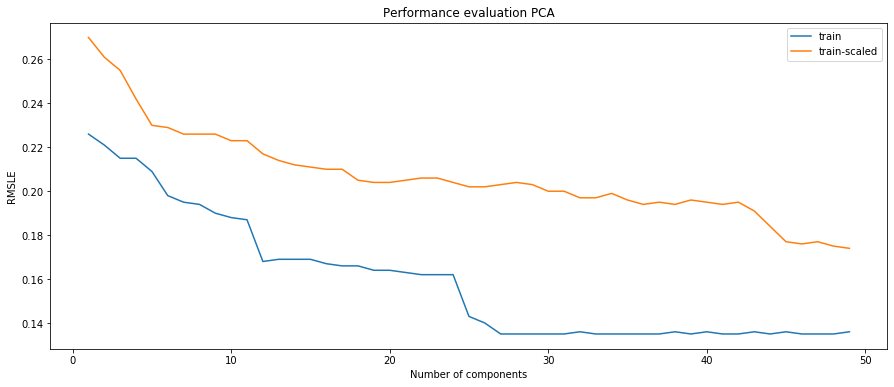

In [205]:
result = []
scaled_result = []
for nComponents in range(1, 50):
    print("{} = {}".format('number of Components: ', nComponents))
    df_PCA_bin = convertToPCA(train_bin, nComponents)
    df_PCA_bin_scaled = convertToPCA(train_bin_scaled, nComponents)
    
    # Presaved LGBMRegressor max_params:
    max_params['params'] = {'gamma': 0.36605181750145344, 'learning_rate': 0.12769640492099332, 'max_depth': 1, 'n_estimators': 1000}
    lgbmMod = LGBMRegressor(**max_params['params'])
    newVal = testModel(df = df_PCA_bin, n_splits = 10, model = lgbmMod, returnVal = True)
    result.append(newVal)
    lgbmMod = LGBMRegressor(**max_params['params'])
    newVal = testModel(df = df_PCA_bin_scaled, n_splits = 10, model = lgbmMod, returnVal = True)
    scaled_result.append(newVal)
    
f, axs = plt.subplots(1, 1, figsize=(15,6))
axs.plot(range(1, len(result)+1), result, label = 'train')
axs.plot(range(1, len(scaled_result)+1), scaled_result, label = 'train-scaled')
plt.legend()
_ = axs.set(xlabel="Number of components", ylabel='RMSLE', title='Performance evaluation PCA')

*Try one set of hyperparameter tuning with PCA:* (Best performance was with > 27 components) <br>
        - Scaled dataset was never better
        - Decision-tree algorithms don't appear to particularly do better with scaled datasets:
        - Scaled datasets will however be applied to linear, lasso & ridge-regression, SVM, kNN, Multi-layer perceptron       

i.a PCA: Random Forest without scaling (Hyperparameter tuning)

In [206]:
df_PCA_bin = convertToPCA(train_bin, 27)
bounds_ = {'n_estimators':(50, 250),
              'min_impurity_decrease':(0.0,0.01),
              'max_depth':(5,100)
             }

max_params = optimiseRF(df_PCA_bin, bounds_)                                      
rfModel = RandomForestRegressor(**max_params['params'])
testModel(df = df_PCA_bin, n_splits = 10, model = rfModel)

|   iter    |  target   | max_depth | min_im... | n_esti... |
-------------------------------------------------------------
|  1        | -0.01789  |  44.62    |  0.007203 |  50.02    |
|  2        | -0.0148   |  33.72    |  0.001468 |  68.47    |
|  3        | -0.01643  |  22.69    |  0.003456 |  129.4    |
|  4        | -0.01679  |  56.19    |  0.004192 |  187.0    |
|  5        | -0.01807  |  24.42    |  0.008781 |  55.48    |
|  6        | -0.01674  |  68.69    |  0.004173 |  161.7    |
|  7        | -0.0153   |  18.34    |  0.001981 |  210.1    |
|  8        | -0.01621  |  96.98    |  0.003134 |  188.5    |
|  9        | -0.01818  |  88.26    |  0.008946 |  67.01    |
|  10       | -0.01508  |  8.71     |  0.001698 |  225.6    |
|  11       | -0.01476  |  5.241    |  0.001428 |  249.6    |
|  12       | -0.01433  |  5.322    |  0.001079 |  249.9    |
|  13       | -0.01618  |  5.277    |  0.003086 |  249.4    |
|  14       | -0.01384  |  5.238    |  0.000678 |  249.6    |
|  15   

ii.a PCA: XGBoost without scaling (Hyperparameter tuning)

In [207]:
df_PCA_bin = convertToPCA(train_bin, 27)
bounds_ = {'n_estimators':(50, 1000),
              'learning_rate':(0.1,0.8),
              'max_depth':(1,10),
               'gamma':(0,1),
             }

max_params = optimiseXGBoost(df_PCA_bin, bounds_)
xgbModel = xgb.XGBRegressor(**max_params['params'])
testModel(df = df_PCA_bin, n_splits = 10, model = xgbModel)

|   iter    |  target   |   gamma   | learni... | max_depth | n_esti... |
-------------------------------------------------------------------------
|  1        | -0.01312  |  0.417    |  0.6042   |  1.001    |  337.2    |
|  2        | -0.01175  |  0.1468   |  0.1646   |  2.676    |  378.3    |
|  3        | -0.01338  |  0.3968   |  0.4772   |  4.773    |  701.0    |
|  4        | -0.01294  |  0.2045   |  0.7147   |  1.246    |  686.9    |
|  5        | -0.01303  |  0.4173   |  0.4911   |  2.263    |  238.2    |
|  6        | -0.01464  |  0.8007   |  0.7778   |  3.821    |  707.7    |
|  7        | -0.01409  |  0.8764   |  0.7262   |  1.765    |  87.1     |
|  8        | -0.01284  |  0.1698   |  0.7147   |  1.885    |  450.1    |
|  9        | -0.01418  |  0.9579   |  0.4732   |  7.227    |  349.7    |
|  10       | -0.01399  |  0.6865   |  0.6842   |  1.165    |  762.6    |
|  11       | -0.01277  |  0.2115   |  0.3861   |  9.983    |  50.25    |
|  12       | -0.01407  |  0.7448   | 

iii.a PCA: LightGBM without scaling (Hyperparameter tuning)

In [208]:
df_PCA_bin = convertToPCA(train_bin, 27)
bounds_ = {
        'gamma': (0,1),
        'max_depth': (1, 10),
        'learning_rate': (0.1, 0.8),
        'n_estimators':(50,1000),
        }
max_params = optimiseLightGBM(df_PCA_bin, bounds_)
lgbmMod = LGBMRegressor(**max_params['params'])
newVal = testModel(df = df_PCA_bin, n_splits = 10, model = lgbmMod)

|   iter    |  target   |   gamma   | learni... | max_depth | n_esti... |
-------------------------------------------------------------------------
|  1        | -0.01105  |  0.417    |  0.6042   |  1.001    |  337.2    |
|  2        | -0.01101  |  0.1468   |  0.1646   |  2.676    |  378.3    |
|  3        | -0.01258  |  0.3968   |  0.4772   |  4.773    |  701.0    |
|  4        | -0.01146  |  0.2045   |  0.7147   |  1.246    |  686.9    |
|  5        | -0.01184  |  0.4173   |  0.4911   |  2.263    |  238.2    |
|  6        | -0.01462  |  0.8007   |  0.7778   |  3.821    |  707.7    |
|  7        | -0.013    |  0.8764   |  0.7262   |  1.765    |  87.1     |
|  8        | -0.0132   |  0.1698   |  0.7147   |  1.885    |  450.1    |
|  9        | -0.01265  |  0.9579   |  0.4732   |  7.227    |  349.7    |
|  10       | -0.01149  |  0.6865   |  0.6842   |  1.165    |  762.6    |
|  11       | -0.01243  |  0.2115   |  0.3861   |  9.983    |  50.25    |
|  12       | -0.01191  |  0.4641   | 

iv.a PCA: Gradient Boosting Regressor without scaling (Hyperparameter tuning)

In [209]:
df_PCA_bin = convertToPCA(train_bin, 27)
bounds_ = {
        'min_impurity_decrease': (0.0,0.01),
        'max_depth': (1, 10),
        'learning_rate': (0.1, 0.8),
        'n_estimators':(50,1000),
        }
max_params = optimiseGradBoost(df_PCA_bin, bounds_)
gbModel = GradientBoostingRegressor(**max_params['params'])
newVal = testModel(df = df_PCA_num, n_splits = 10, model = gbModel)

|   iter    |  target   | learni... | max_depth | min_im... | n_esti... |
-------------------------------------------------------------------------
|  1        | -0.01318  |  0.3919   |  7.483    |  1.144e-0 |  337.2    |
|  2        | -0.01103  |  0.2027   |  1.831    |  0.001863 |  378.3    |
|  3        | -0.01239  |  0.3777   |  5.849    |  0.004192 |  701.0    |
|  4        | -0.01365  |  0.2431   |  8.903    |  0.000273 |  686.9    |
|  5        | -0.01257  |  0.3921   |  6.028    |  0.001404 |  238.2    |
|  6        | -0.0161   |  0.6605   |  9.714    |  0.003134 |  707.7    |
|  7        | -0.01611  |  0.7135   |  9.051    |  0.000850 |  87.1     |
|  8        | -0.01376  |  0.2189   |  8.903    |  0.000983 |  450.1    |
|  9        | -0.01582  |  0.7705   |  5.798    |  0.006919 |  349.7    |
|  10       | -0.01515  |  0.5806   |  8.512    |  0.000182 |  762.6    |
|  11       | -0.0111   |  0.3333   |  1.087    |  0.003923 |  999.1    |
|  12       | -0.01063  |  0.1414   | 

- Check for multicollinearity risk within the dataset:

In [210]:
df_PCA_bin = convertToPCA(train_bin, 27)
checkVarInfFactor(df_PCA_bin)

*No output: Therefore no evidence of multi-collinearity risks!*

Check optimum number of components for scaled PCA dataset
- better scaling before or after?

number of Components:  = 1
RMSLE Value For Kf_i:  0.28, 0.26, 0.26, 0.27, 0.25, 0.29, 0.28, 0.26, 0.27, 0.28, Average RMSLE:  0.27
RMSLE Value For Kf_i:  0.22, 0.22, 0.22, 0.2, 0.23, 0.22, 0.23, 0.25, 0.26, 0.21, Average RMSLE:  0.226
number of Components:  = 2
RMSLE Value For Kf_i:  0.27, 0.25, 0.26, 0.26, 0.24, 0.28, 0.26, 0.25, 0.27, 0.27, Average RMSLE:  0.261
RMSLE Value For Kf_i:  0.21, 0.22, 0.2, 0.2, 0.22, 0.21, 0.22, 0.24, 0.25, 0.22, Average RMSLE:  0.22
number of Components:  = 3
RMSLE Value For Kf_i:  0.26, 0.25, 0.25, 0.26, 0.23, 0.27, 0.24, 0.25, 0.27, 0.27, Average RMSLE:  0.255
RMSLE Value For Kf_i:  0.2, 0.21, 0.2, 0.19, 0.22, 0.2, 0.22, 0.24, 0.24, 0.21, Average RMSLE:  0.215
number of Components:  = 4
RMSLE Value For Kf_i:  0.24, 0.23, 0.23, 0.24, 0.22, 0.26, 0.23, 0.24, 0.27, 0.26, Average RMSLE:  0.242
RMSLE Value For Kf_i:  0.2, 0.22, 0.21, 0.19, 0.22, 0.2, 0.22, 0.24, 0.24, 0.21, Average RMSLE:  0.215
number of Components:  = 5
RMSLE Value For Kf_i:  0.23, 0.23, 

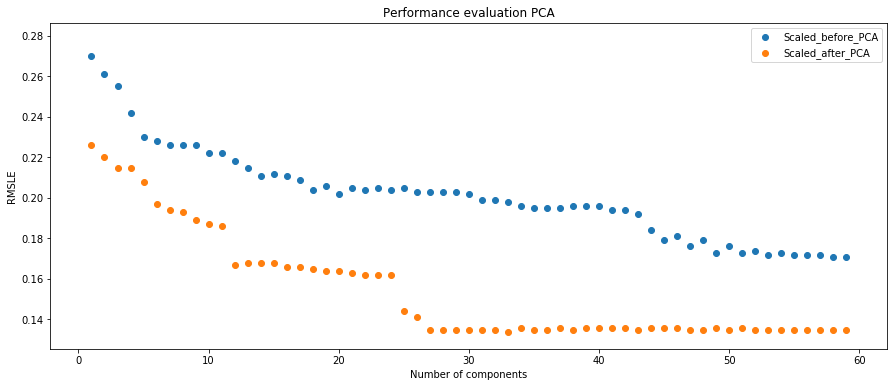

In [37]:
result = []
scaled_result = []
f, axs = plt.subplots(1, 1, figsize=(15,6))
max_params = {}
for nComponents in range(1, 60):
    print("{} = {}".format('number of Components: ', nComponents))
    # Scale before
    df_PCA_bin_scaled = scaleData(train_bin)
    df_PCA_bin_scaled_before = convertToPCA(df_PCA_bin_scaled, nComponents)
    
    # Scale after
    df_PCA_bin = convertToPCA(train_bin, nComponents)
    df_PCA_bin_scaled_after = scaleData(df_PCA_bin)
        
    # Presaved LGBMRegressor max_params:
    max_params['params'] = {'gamma': 0.36605181750145344, 'learning_rate': 0.12769640492099332, 'max_depth': 1, 'n_estimators': 1000}
    lgbmMod = LGBMRegressor(**max_params['params'])
    newVal = testModel(df = df_PCA_bin_scaled_before, n_splits = 10, model = lgbmMod, returnVal = True)
    result.append(newVal)
    lgbmMod = LGBMRegressor(**max_params['params'])
    newVal = testModel(df = df_PCA_bin_scaled_after, n_splits = 10, model = lgbmMod, returnVal = True)
    scaled_result.append(newVal)
        
axs.scatter(range(1, len(result)+1), result, label = 'Scaled_before_PCA')
axs.scatter(range(1, len(scaled_result)+1), scaled_result, label = 'Scaled_after_PCA')
plt.legend()
_ = axs.set(xlabel="Number of components", ylabel='RMSLE', title='Performance evaluation PCA')

v. Try kNN Regressor with scaling (Hyperparameter tuning)

In [38]:
df_PCA_bin = convertToPCA(train_bin, 27)
df_PCA_bin_scaled = scaleData(df_PCA_bin)
bounds_ = {
        'p': (1,2),
        'n_neighbors': (1, 30),
        'leaf_size': (1, 50),
        }
max_params = optimiseKNN(df_PCA_bin_scaled, bounds_)
kNNmodel = KNeighborsRegressor(**max_params['params'])
newVal = testModel(df = df_PCA_bin_scaled, n_splits = 10, model = kNNmodel)

|   iter    |  target   | leaf_size | n_neig... |     p     |
-------------------------------------------------------------
|  1        | -0.01708  |  21.43    |  21.89    |  1.0      |
|  2        | -0.01661  |  15.81    |  5.256    |  1.092    |
|  3        | -0.01656  |  10.13    |  11.02    |  1.397    |
|  4        | -0.01927  |  27.4     |  13.16    |  1.685    |
|  5        | -0.01732  |  11.02    |  26.47    |  1.027    |
|  6        | -0.01927  |  33.85    |  13.1     |  1.559    |
|  7        | -0.01889  |  7.879    |  6.745    |  1.801    |
|  8        | -0.01916  |  48.44    |  10.09    |  1.692    |
|  9        | -0.01738  |  43.94    |  26.94    |  1.085    |
|  10       | -0.01898  |  2.914    |  5.925    |  1.878    |
|  11       | -0.02058  |  1.258    |  29.99    |  1.793    |
|  12       | -0.02411  |  49.95    |  1.083    |  1.768    |
|  13       | -0.02075  |  2.056    |  1.154    |  1.01     |
|  14       | -0.01745  |  48.9     |  29.93    |  1.006    |
|  15   

vi. Try SVR Regressor with scaling (Hyperparameter tuning)

In [39]:
df_PCA_bin = convertToPCA(train_bin, 27)
df_PCA_bin_scaled = scaleData(df_PCA_bin)

bounds_ = {
        #'kernel': ('linear', 'rbf','poly'),
        'C': (1.5, 10),
        'gamma': (1e-7, 1e-4),
        'epsilon':(0.1,0.5),
        }
max_params = optimiseSVR(df_PCA_bin_scaled, bounds_)
svrModel = SVR(**max_params['params'])
newVal = testModel(df = df_PCA_bin_scaled, n_splits = 10, model = svrModel)

|   iter    |  target   |     C     |  epsilon  |   gamma   |
-------------------------------------------------------------
|  1        | -0.03046  |  5.045    |  0.3881   |  1.114e-0 |
|  2        | -0.0304   |  4.07     |  0.1587   |  9.325e-0 |
|  3        | -0.03028  |  3.083    |  0.2382   |  3.974e-0 |
|  4        | -0.03001  |  6.08     |  0.2677   |  6.855e-0 |
|  5        | -0.03053  |  3.238    |  0.4512   |  2.836e-0 |
|  6        | -0.03002  |  7.199    |  0.2669   |  5.591e-0 |
|  7        | -0.03019  |  2.693    |  0.1792   |  8.009e-0 |
|  8        | -0.02969  |  9.73     |  0.2254   |  6.926e-0 |
|  9        | -0.03049  |  8.949    |  0.4578   |  8.596e-0 |
|  10       | -0.03025  |  1.832    |  0.1679   |  8.783e-0 |
|  11       | -0.02989  |  9.956    |  0.3514   |  6.893e-0 |
|  12       | -0.02986  |  9.977    |  0.1415   |  4.831e-0 |
|  13       | -0.02994  |  9.933    |  0.3546   |  6.393e-0 |
|  14       | -0.02978  |  9.942    |  0.3804   |  9.111e-0 |
|  15   

viii. Try MLP Regressor with scaling (Hyperparameter tuning)

In [40]:
df_PCA_bin = convertToPCA(train_bin, 27)
df_PCA_bin_scaled = scaleData(df_PCA_bin)

bounds_ = {
        #'kernel': ('linear', 'rbf','poly'),
        'hidden_layer_sizes': (10, 150),
        'learning_rate_init': (1e-7, 1),
        'alpha':(1e-7, 1),
        }
max_params = optimiseMLP(df_PCA_bin_scaled, bounds_)
mlpModel = MLPRegressor(**max_params['params'])
newVal = testModel(df = df_PCA_bin_scaled, n_splits = 10, model = mlpModel)

|   iter    |  target   |   alpha   | hidden... | learni... |
-------------------------------------------------------------
|  1        | -0.06744  |  0.417    |  110.8    |  0.000114 |
|  2        | -0.01108  |  0.3023   |  30.55    |  0.09234  |
|  3        | -0.01429  |  0.1863   |  58.38    |  0.3968   |
|  4        | -0.01656  |  0.5388   |  68.69    |  0.6852   |
|  5        | -0.01083  |  0.2045   |  132.9    |  0.02739  |
|  6        | -0.02336  |  0.6705   |  68.42    |  0.5587   |
|  7        | -0.02387  |  0.1404   |  37.73    |  0.8007   |
|  8        | -0.01987  |  0.9683   |  53.88    |  0.6923   |
|  9        | -0.01483  |  0.8764   |  135.2    |  0.08504  |
|  10       | -0.02272  |  0.03905  |  33.78    |  0.8781   |
|  11       | -2.071    |  1.043e-0 |  10.0     |  1e-07    |
|  12       | -1.205    |  1e-07    |  90.38    |  1e-07    |
|  13       | -0.02186  |  1e-07    |  150.0    |  1.0      |
|  14       | -0.02003  |  1.0      |  120.6    |  1.0      |
|  15   

ix. Try linear regression with scaling 

In [41]:
lModel = LinearRegression()
df_PCA_bin = convertToPCA(train_bin, 27)
# Rescale between 0 and 1 to avoid value-errors:
df_PCA_bin_scaled = scaleData(df_PCA_bin)
# Use best feature combinations and trial 
newVal = testModel(df = df_PCA_bin_scaled, n_splits = 10, model = lModel)

RMSLE Value For Kf_i:  0.12, 0.12, 0.11, 0.11, 0.12, 0.13, 0.11, 0.2, 0.15, 0.12, Average RMSLE:  0.129


x. Try lasso regression with scaling (Hyperparameter tuning)

In [42]:
df_PCA_bin = convertToPCA(train_bin, 27)
# Rescale between 0 and 1 to avoid value-errors:
df_PCA_bin_scaled = scaleData(df_PCA_bin)

bounds_ = {
        'alpha': (0.0000001,1),
        }

max_params = optimiseLasso(df_PCA_bin_scaled, bounds_)
lassoModel = Lasso(**max_params['params'])
newVal = testModel(df = df_PCA_bin_scaled, n_splits = 10, model = lassoModel)

|   iter    |  target   |   alpha   |
-------------------------------------
|  1        | -0.03042  |  0.417    |
|  2        | -0.03042  |  0.7203   |
|  3        | -0.01008  |  0.000114 |
|  4        | -0.03042  |  0.3023   |
|  5        | -0.03042  |  0.1468   |
|  6        | -0.03042  |  0.09234  |
|  7        | -0.03042  |  0.1863   |
|  8        | -0.03042  |  0.3456   |
|  9        | -0.03042  |  0.3968   |
|  10       | -0.03042  |  0.5388   |
|  11       | -0.03042  |  1.0      |
|  12       | -0.0101   |  1e-07    |
|  13       | -0.0101   |  1e-07    |
|  14       | -0.0101   |  1e-07    |
|  15       | -0.0101   |  1e-07    |
|  16       | -0.0101   |  2.155e-0 |
|  17       | -0.0101   |  7.511e-0 |
|  18       | -0.0101   |  6.127e-0 |
|  19       | -0.0101   |  6.127e-0 |
|  20       | -0.0101   |  3.467e-0 |
|  21       | -0.0101   |  7.462e-0 |
|  22       | -0.0101   |  7.462e-0 |
|  23       | -0.0101   |  5.497e-0 |
|  24       | -0.0101   |  5.97e-07 |
|  25       

xi. Try ridge regression with scaling (Hyperparameter tuning)

In [43]:
df_PCA_bin = convertToPCA(train_bin, 27)
# Rescale between 0 and 1 to avoid value-errors:
df_PCA_bin_scaled = scaleData(df_PCA_bin)

bounds_ = {
        'alpha': (0.0000001,1),
        }

max_params = optimiseRidge(df_PCA_bin_scaled, bounds_)
ridgeModel = Ridge(**max_params['params'])
newVal = testModel(df = df_PCA_bin_scaled, n_splits = 10, model = ridgeModel)

|   iter    |  target   |   alpha   |
-------------------------------------
|  1        | -0.01015  |  0.417    |
|  2        | -0.01027  |  0.7203   |
|  3        | -0.01009  |  0.000114 |
|  4        | -0.01012  |  0.3023   |
|  5        | -0.0101   |  0.1468   |
|  6        | -0.01009  |  0.09234  |
|  7        | -0.0101   |  0.1863   |
|  8        | -0.01013  |  0.3456   |
|  9        | -0.01015  |  0.3968   |
|  10       | -0.01019  |  0.5388   |
|  11       | -0.0101   |  0.1418   |
|  12       | -0.01027  |  0.7309   |
|  13       | -0.01015  |  0.3906   |
|  14       | -0.01029  |  0.7741   |
|  15       | -0.01013  |  0.3443   |
|  16       | -0.0101   |  0.1676   |
|  17       | -0.0103   |  0.7919   |
|  18       | -0.01023  |  0.6207   |
|  19       | -0.0102   |  0.567    |
|  20       | -0.01029  |  0.7626   |
|  21       | -0.01011  |  0.2531   |
|  22       | -0.01035  |  0.9035   |
|  23       | -0.01023  |  0.6196   |
|  24       | -0.01039  |  0.9759   |
|  25       

**Summary for binary-encoded dataset features:** 
- Best: lgbm result with & without scaling/PCA of 0.122
- 2nd: Gradient Boosting without & with scaling/PCA of 0.124, 0.125
- 3rd: XGBoost without & with scaling/PCA of 0.132, 0.137
- Linear, Ridge & Lasso regression do well for simpler models with scaled datasets of 0.144, 0,144 & 0.143 respectively 
- XGBoost with no scaling/PCA does well with 

##### One-hot-encoded feature datasets: ----------------------------------------------------------------------------------------------------------------

- Given decision trees suffer from sparsity with one-hot encoded features, all datasets will be firstly processed with PCA:
    - Therefore comparisons will only be given between scaled & unscaled datasets but both will contain PCA based feature-reduction preprocessing

*Move SalePrice to end*

In [72]:
cols = list(train_one)
cols.insert(len(cols)-1, cols.pop(cols.index('SalePrice')))
train_one = train_one[cols]
df_PCA_one_scaled = scaleData(train_one)
df_PCA_one_scaled.head(2)

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,MSZoning_1,MSZoning_2,MSZoning_3,MSZoning_4,Street_1,LotShape_1,LotShape_2,LotShape_3,LandContour_1,LandContour_2,LandContour_3,Utilities_1,LotConfig_1,LotConfig_2,LotConfig_3,LotConfig_4,LandSlope_1,LandSlope_2,Neighborhood_1,Neighborhood_2,Neighborhood_3,Neighborhood_4,Neighborhood_5,Neighborhood_6,Neighborhood_7,Neighborhood_8,Neighborhood_9,Neighborhood_10,Neighborhood_11,Neighborhood_12,Neighborhood_13,Neighborhood_14,Neighborhood_15,Neighborhood_16,Neighborhood_17,Neighborhood_18,Neighborhood_19,Neighborhood_20,Neighborhood_21,Neighborhood_22,Neighborhood_23,Neighborhood_24,Condition1_1,Condition1_2,Condition1_3,Condition1_4,Condition1_5,Condition1_6,Condition1_7,Condition1_8,Condition2_1,Condition2_2,Condition2_3,Condition2_4,Condition2_5,Condition2_6,BldgType_1,BldgType_2,BldgType_3,BldgType_4,HouseStyle_1,HouseStyle_2,HouseStyle_3,HouseStyle_4,HouseStyle_5,HouseStyle_6,HouseStyle_7,RoofStyle_1,RoofStyle_2,RoofStyle_3,RoofStyle_4,RoofStyle_5,RoofMatl_1,RoofMatl_2,RoofMatl_3,RoofMatl_4,RoofMatl_5,RoofMatl_6,Exterior1st_1,Exterior1st_2,Exterior1st_3,Exterior1st_4,Exterior1st_5,Exterior1st_6,Exterior1st_7,Exterior1st_8,Exterior1st_9,Exterior1st_10,Exterior1st_11,Exterior1st_12,Exterior1st_13,Exterior1st_14,Exterior2nd_1,Exterior2nd_2,Exterior2nd_3,Exterior2nd_4,Exterior2nd_5,Exterior2nd_6,Exterior2nd_7,Exterior2nd_8,Exterior2nd_9,Exterior2nd_10,Exterior2nd_11,Exterior2nd_12,Exterior2nd_13,Exterior2nd_14,Exterior2nd_15,MasVnrType_1,MasVnrType_2,MasVnrType_3,MasVnrType_4,ExterQual_1,ExterQual_2,ExterQual_3,ExterCond_1,ExterCond_2,ExterCond_3,ExterCond_4,Foundation_1,Foundation_2,Foundation_3,Foundation_4,Foundation_5,BsmtQual_1,BsmtQual_2,BsmtQual_3,BsmtQual_4,BsmtCond_1,BsmtCond_2,BsmtCond_3,BsmtCond_4,BsmtExposure_1,BsmtExposure_2,BsmtExposure_3,BsmtExposure_4,BsmtFinType1_1,BsmtFinType1_2,BsmtFinType1_3,BsmtFinType1_4,BsmtFinType1_5,BsmtFinType1_6,BsmtFinType2_1,BsmtFinType2_2,BsmtFinType2_3,BsmtFinType2_4,BsmtFinType2_5,BsmtFinType2_6,Heating_1,Heating_2,Heating_3,Heating_4,Heating_5,HeatingQC_1,HeatingQC_2,HeatingQC_3,HeatingQC_4,CentralAir_1,Electrical_1,Electrical_2,Electrical_3,Electrical_4,KitchenQual_1,KitchenQual_2,KitchenQual_3,Functional_1,Functional_2,Functional_3,Functional_4,Functional_5,Functional_6,GarageType_1,GarageType_2,GarageType_3,GarageType_4,GarageType_5,GarageType_6,GarageFinish_1,GarageFinish_2,GarageFinish_3,GarageQual_1,GarageQual_2,GarageQual_3,GarageQual_4,GarageQual_5,GarageCond_1,GarageCond_2,GarageCond_3,GarageCond_4,GarageCond_5,PavedDrive_1,PavedDrive_2,SaleType_1,SaleType_2,SaleType_3,SaleType_4,SaleType_5,SaleType_6,SaleType_7,SaleType_8,SaleCondition_1,SaleCondition_2,SaleCondition_3,SaleCondition_4,SaleCondition_5,SalePrice
0,0.000000,0.235294,0.273292,0.337851,0.666667,0.500,0.949275,0.883333,0.597109,0.312389,0.0,0.064212,0.266999,0.180373,0.413559,0.0,0.316905,0.333333,0.0,0.666667,0.5,0.375,0.333333,0.500000,0.000000,0.936364,0.5,0.394245,0.000000,0.145933,0.0,0.0,0.0,0.0,0.0,0.090909,0.50,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0

- **With PCA: Variety of models**

*Do a test to confirm ideal number of components for machine-learning*

number of Components:  = 1
RMSLE Value For Kf_i:  0.27, 0.26, 0.26, 0.27, 0.24, 0.29, 0.28, 0.26, 0.29, 0.28, Average RMSLE:  0.269
RMSLE Value For Kf_i:  0.22, 0.22, 0.22, 0.2, 0.23, 0.22, 0.23, 0.25, 0.26, 0.21, Average RMSLE:  0.226
number of Components:  = 2
RMSLE Value For Kf_i:  0.25, 0.25, 0.25, 0.26, 0.23, 0.28, 0.26, 0.25, 0.28, 0.27, Average RMSLE:  0.258
RMSLE Value For Kf_i:  0.21, 0.22, 0.2, 0.2, 0.22, 0.21, 0.22, 0.24, 0.25, 0.22, Average RMSLE:  0.22
number of Components:  = 3
RMSLE Value For Kf_i:  0.25, 0.24, 0.25, 0.25, 0.23, 0.27, 0.25, 0.25, 0.27, 0.27, Average RMSLE:  0.253
RMSLE Value For Kf_i:  0.2, 0.21, 0.2, 0.19, 0.22, 0.2, 0.22, 0.24, 0.24, 0.21, Average RMSLE:  0.215
number of Components:  = 4
RMSLE Value For Kf_i:  0.25, 0.23, 0.23, 0.24, 0.22, 0.26, 0.25, 0.25, 0.28, 0.26, Average RMSLE:  0.247
RMSLE Value For Kf_i:  0.2, 0.22, 0.21, 0.19, 0.22, 0.2, 0.22, 0.24, 0.24, 0.21, Average RMSLE:  0.215
number of Components:  = 5
RMSLE Value For Kf_i:  0.24, 0.23,

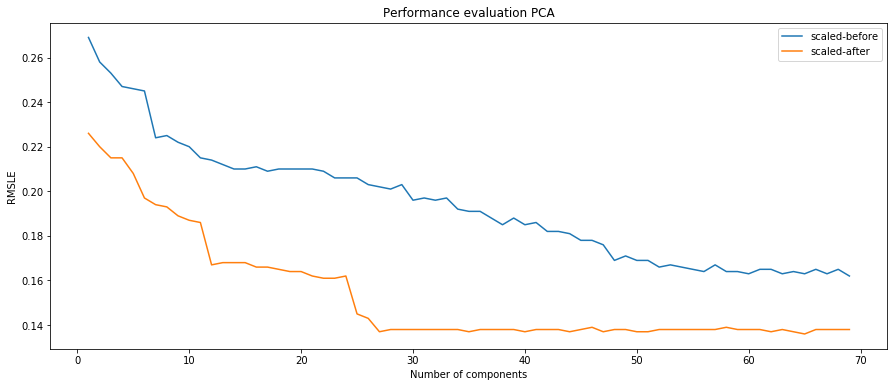

In [73]:
result = []
scaled_result = []
for nComponents in range(1, 70):
    print("{} = {}".format('number of Components: ', nComponents))
    
    # Scale before
    df_PCA_one_scaled = scaleData(train_one)
    df_PCA_one_scaled_before = convertToPCA(df_PCA_one_scaled, nComponents)
    
    # Scale after
    df_PCA_one = convertToPCA(train_one, nComponents)
    df_PCA_one_scaled_after = scaleData(df_PCA_one)

    # Keep LGBMRegressor max_params from numerical dataset:
 
    max_params['params'] = {'gamma': 0.36605181750145344, 'learning_rate': 0.12769640492099332, 'max_depth': 1, 'n_estimators': 1000}
    lgbmMod = LGBMRegressor(**max_params['params'])
    newVal = testModel(df = df_PCA_one_scaled_before, n_splits = 10, model = lgbmMod, returnVal = True)
    result.append(newVal)
    lgbmMod = LGBMRegressor(**max_params['params'])
    newVal = testModel(df = df_PCA_one_scaled_after, n_splits = 10, model = lgbmMod, returnVal = True)
    scaled_result.append(newVal)
    
f, axs = plt.subplots(1, 1, figsize=(15,6))
axs.plot(range(1, len(result)+1), result, label = 'scaled-before')
axs.plot(range(1, len(scaled_result)+1), scaled_result, label = 'scaled-after')
plt.legend()
_ = axs.set(xlabel="Number of components", ylabel='RMSLE', title='Performance evaluation PCA')

Try one set of hyperparameter tuning with PCA: (Best performance was with 65 components)

    - Scaling after worked better (markedly)
    - Therefore all algorithms will be fed post-scaled PCA datasets

i.a PCA: Random Forest with scaling (Hyperparameter tuning)

In [78]:
nComponents = 65

In [79]:
df_PCA_one = convertToPCA(train_one, nComponents)
df_PCA_one = scaleData(df_PCA_one)

bounds_ = {'n_estimators':(50, 250),
              'min_impurity_decrease':(0.0,0.01),
              'max_depth':(5,100)
             }

max_params = optimiseRF(df_PCA_one, bounds_)                                      
rfModel = RandomForestRegressor(**max_params['params'])
testModel(df = df_PCA_one, n_splits = 10, model = rfModel)

|   iter    |  target   | max_depth | min_im... | n_esti... |
-------------------------------------------------------------
|  1        | -0.01791  |  44.62    |  0.007203 |  50.02    |
|  2        | -0.01472  |  33.72    |  0.001468 |  68.47    |
|  3        | -0.01631  |  22.69    |  0.003456 |  129.4    |
|  4        | -0.01674  |  56.19    |  0.004192 |  187.0    |
|  5        | -0.01813  |  24.42    |  0.008781 |  55.48    |
|  6        | -0.01672  |  68.69    |  0.004173 |  161.7    |
|  7        | -0.01513  |  18.34    |  0.001981 |  210.1    |
|  8        | -0.01612  |  96.98    |  0.003134 |  188.5    |
|  9        | -0.01816  |  88.26    |  0.008946 |  67.01    |
|  10       | -0.01486  |  8.71     |  0.001698 |  225.6    |
|  11       | -0.01456  |  5.241    |  0.001428 |  249.6    |
|  12       | -0.01415  |  5.322    |  0.001079 |  249.9    |
|  13       | -0.01604  |  5.277    |  0.003086 |  249.4    |
|  14       | -0.01378  |  5.238    |  0.000678 |  249.6    |
|  15   

ii.a PCA: XGBoost with scaling (Hyperparameter tuning)

In [80]:
df_PCA_one = convertToPCA(train_one, nComponents)
df_PCA_one = scaleData(df_PCA_one)
bounds_ = {'n_estimators':(50, 1000),
              'learning_rate':(0.1,0.8),
              'max_depth':(1,10),
               'gamma':(0,1),
             }

max_params = optimiseXGBoost(df_PCA_one, bounds_)
xgbModel = xgb.XGBRegressor(**max_params['params'])
testModel(df = df_PCA_one, n_splits = 10, model = xgbModel)

|   iter    |  target   |   gamma   | learni... | max_depth | n_esti... |
-------------------------------------------------------------------------
|  1        | -0.01312  |  0.417    |  0.6042   |  1.001    |  337.2    |
|  2        | -0.01186  |  0.1468   |  0.1646   |  2.676    |  378.3    |
|  3        | -0.01356  |  0.3968   |  0.4772   |  4.773    |  701.0    |
|  4        | -0.01301  |  0.2045   |  0.7147   |  1.246    |  686.9    |
|  5        | -0.01296  |  0.4173   |  0.4911   |  2.263    |  238.2    |
|  6        | -0.01484  |  0.8007   |  0.7778   |  3.821    |  707.7    |
|  7        | -0.01411  |  0.8764   |  0.7262   |  1.765    |  87.1     |
|  8        | -0.01293  |  0.1698   |  0.7147   |  1.885    |  450.1    |
|  9        | -0.01407  |  0.9579   |  0.4732   |  7.227    |  349.7    |
|  10       | -0.01394  |  0.6865   |  0.6842   |  1.165    |  762.6    |
|  11       | -0.01296  |  0.2115   |  0.3861   |  9.983    |  50.25    |
|  12       | -0.01424  |  0.7448   | 

iii.a PCA: LightGBM with scaling (Hyperparameter tuning)

In [81]:
df_PCA_one = convertToPCA(train_one, nComponents)
df_PCA_one = scaleData(df_PCA_one)
bounds_ = {
        'gamma': (0,1),
        'max_depth': (1, 10),
        'learning_rate': (0.1, 0.8),
        'n_estimators':(50,1000),
        }
max_params = optimiseLightGBM(df_PCA_one, bounds_)
lgbmMod = LGBMRegressor(**max_params['params'])
newVal = testModel(df = df_PCA_one, n_splits = 10, model = lgbmMod)

|   iter    |  target   |   gamma   | learni... | max_depth | n_esti... |
-------------------------------------------------------------------------
|  1        | -0.01186  |  0.417    |  0.6042   |  1.001    |  337.2    |
|  2        | -0.01129  |  0.1468   |  0.1646   |  2.676    |  378.3    |
|  3        | -0.013    |  0.3968   |  0.4772   |  4.773    |  701.0    |
|  4        | -0.01244  |  0.2045   |  0.7147   |  1.246    |  686.9    |
|  5        | -0.01224  |  0.4173   |  0.4911   |  2.263    |  238.2    |
|  6        | -0.01491  |  0.8007   |  0.7778   |  3.821    |  707.7    |
|  7        | -0.01317  |  0.8764   |  0.7262   |  1.765    |  87.1     |
|  8        | -0.01333  |  0.1698   |  0.7147   |  1.885    |  450.1    |
|  9        | -0.01344  |  0.9579   |  0.4732   |  7.227    |  349.7    |
|  10       | -0.01241  |  0.6865   |  0.6842   |  1.165    |  762.6    |
|  11       | -0.01266  |  0.2115   |  0.3861   |  9.983    |  50.25    |
|  12       | -0.0157   |  0.7043   | 

iv.a PCA: Gradient Boosting Regressor with scaling (Hyperparameter tuning)

In [82]:
df_PCA_one = convertToPCA(train_one, nComponents)
df_PCA_one = scaleData(df_PCA_one)
bounds_ = {
        'min_impurity_decrease': (0.0,0.01),
        'max_depth': (1, 10),
        'learning_rate': (0.1, 0.8),
        'n_estimators':(50,1000),
        }
max_params = optimiseGradBoost(df_PCA_one, bounds_)
gbModel = GradientBoostingRegressor(**max_params['params'])
newVal = testModel(df = df_PCA_one, n_splits = 10, model = gbModel)

|   iter    |  target   | learni... | max_depth | min_im... | n_esti... |
-------------------------------------------------------------------------
|  1        | -0.01304  |  0.3919   |  7.483    |  1.144e-0 |  337.2    |
|  2        | -0.01116  |  0.2027   |  1.831    |  0.001863 |  378.3    |
|  3        | -0.01266  |  0.3777   |  5.849    |  0.004192 |  701.0    |
|  4        | -0.01372  |  0.2431   |  8.903    |  0.000273 |  686.9    |
|  5        | -0.01303  |  0.3921   |  6.028    |  0.001404 |  238.2    |
|  6        | -0.01562  |  0.6605   |  9.714    |  0.003134 |  707.7    |
|  7        | -0.01576  |  0.7135   |  9.051    |  0.000850 |  87.1     |
|  8        | -0.01355  |  0.2189   |  8.903    |  0.000983 |  450.1    |
|  9        | -0.01552  |  0.7705   |  5.798    |  0.006919 |  349.7    |
|  10       | -0.01494  |  0.5806   |  8.512    |  0.000182 |  762.6    |
|  11       | -0.01148  |  0.3333   |  1.087    |  0.003923 |  999.1    |
|  12       | -0.01077  |  0.1414   | 

- Ensure no risks of multicollinearity for the following algorithms

In [83]:
checkVarInfFactor(df_PCA_one)

*No output therefore no risk of multicollinearity*

v. Try kNN Regressor with scaling (Hyperparameter tuning)

In [84]:
df_PCA_one = convertToPCA(train_one, nComponents)
df_PCA_one = scaleData(df_PCA_one)
bounds_ = {
        'p': (1,2),
        'n_neighbors': (1, 30),
        'leaf_size': (1, 50),
        }
max_params = optimiseKNN(df_PCA_one, bounds_)
kNNmodel = KNeighborsRegressor(**max_params['params'])
newVal = testModel(df = df_PCA_one, n_splits = 10, model = kNNmodel)

|   iter    |  target   | leaf_size | n_neig... |     p     |
-------------------------------------------------------------
|  1        | -0.0185   |  21.43    |  21.89    |  1.0      |
|  2        | -0.01641  |  15.81    |  5.256    |  1.092    |
|  3        | -0.01679  |  10.13    |  11.02    |  1.397    |
|  4        | -0.02131  |  27.4     |  13.16    |  1.685    |
|  5        | -0.01909  |  11.02    |  26.47    |  1.027    |
|  6        | -0.02131  |  33.85    |  13.1     |  1.559    |
|  7        | -0.01986  |  7.879    |  6.745    |  1.801    |
|  8        | -0.02082  |  48.44    |  10.09    |  1.692    |
|  9        | -0.01922  |  43.94    |  26.94    |  1.085    |
|  10       | -0.0197   |  2.914    |  5.925    |  1.878    |
|  11       | -0.01961  |  1.014    |  29.7     |  1.236    |
|  12       | -0.02045  |  1.004    |  1.036    |  1.269    |
|  13       | -0.02361  |  1.086    |  29.94    |  1.927    |
|  14       | -0.02045  |  48.81    |  1.155    |  1.014    |
|  15   

vi. Try SVR Regressor with scaling (Hyperparameter tuning)

In [85]:
df_PCA_one = convertToPCA(train_one, nComponents)
df_PCA_one = scaleData(df_PCA_one)
bounds_ = {
        #'kernel': ('linear', 'rbf','poly'),
        'C': (1.5, 10),
        'gamma': (1e-7, 1e-4),
        'epsilon':(0.1,0.5),
        }
max_params = optimiseSVR(df_PCA_one, bounds_)
svrModel = SVR(**max_params['params'])
newVal = testModel(df = df_PCA_one, n_splits = 10, model = svrModel)

|   iter    |  target   |     C     |  epsilon  |   gamma   |
-------------------------------------------------------------
|  1        | -0.03046  |  5.045    |  0.3881   |  1.114e-0 |
|  2        | -0.0304   |  4.07     |  0.1587   |  9.325e-0 |
|  3        | -0.03029  |  3.083    |  0.2382   |  3.974e-0 |
|  4        | -0.03002  |  6.08     |  0.2677   |  6.855e-0 |
|  5        | -0.03053  |  3.238    |  0.4512   |  2.836e-0 |
|  6        | -0.03003  |  7.199    |  0.2669   |  5.591e-0 |
|  7        | -0.03019  |  2.693    |  0.1792   |  8.009e-0 |
|  8        | -0.0297   |  9.73     |  0.2254   |  6.926e-0 |
|  9        | -0.03049  |  8.949    |  0.4578   |  8.596e-0 |
|  10       | -0.03026  |  1.832    |  0.1679   |  8.783e-0 |
|  11       | -0.0299   |  9.956    |  0.3514   |  6.893e-0 |
|  12       | -0.03015  |  9.993    |  0.3595   |  3.935e-0 |
|  13       | -0.03033  |  9.998    |  0.4523   |  3.27e-05 |
|  14       | -0.03042  |  1.592    |  0.3019   |  1.628e-0 |
|  15   

viii. Try MLP Regressor with scaling (Hyperparameter tuning)

In [86]:
df_PCA_one = convertToPCA(train_one, nComponents)
df_PCA_one = scaleData(df_PCA_one)
# Rescale between 0 and 1 to avoid value-errors:

bounds_ = {
        #'kernel': ('linear', 'rbf','poly'),
        'hidden_layer_sizes': (10, 150),
        'learning_rate_init': (1e-7, 1),
        'alpha':(1e-7, 1),
        }
max_params = optimiseMLP(df_PCA_one, bounds_)
mlpModel = MLPRegressor(**max_params['params'])
newVal = testModel(df = df_PCA_one, n_splits = 10, model = mlpModel)

|   iter    |  target   |   alpha   | hidden... | learni... |
-------------------------------------------------------------
|  1        | -0.04649  |  0.417    |  110.8    |  0.000114 |
|  2        | -0.01804  |  0.3023   |  30.55    |  0.09234  |
|  3        | -0.02385  |  0.1863   |  58.38    |  0.3968   |
|  4        | -0.1646   |  0.5388   |  68.69    |  0.6852   |
|  5        | -0.0224   |  0.2045   |  132.9    |  0.02739  |
|  6        | -0.06482  |  0.6705   |  68.42    |  0.5587   |
|  7        | -0.02984  |  0.1404   |  37.73    |  0.8007   |
|  8        | -0.6543   |  0.9683   |  53.88    |  0.6923   |
|  9        | -0.01881  |  0.8764   |  135.2    |  0.08504  |
|  10       | -0.03203  |  0.03905  |  33.78    |  0.8781   |
|  11       | -0.03043  |  1.0      |  10.0     |  1.0      |
|  12       | -0.05373  |  1e-07    |  150.0    |  1.0      |
|  13       | -1.164    |  1.0      |  94.81    |  1e-07    |
|  14       | -0.06539  |  1.0      |  121.1    |  1.0      |
|  15   

ix. Try linear regression with scaling 

In [87]:
lModel = LinearRegression()
df_PCA_one = convertToPCA(train_one, nComponents)
df_PCA_one = scaleData(df_PCA_one)
# Use best feature combinations and trial 
newVal = testModel(df = df_PCA_one, n_splits = 10, model = lModel)

RMSLE Value For Kf_i:  0.12, 0.12, 0.11, 0.1, 0.13, 0.12, 0.11, 0.2, 0.15, 0.12, Average RMSLE:  0.126


x. Try lasso regression with scaling (Hyperparameter tuning)

In [88]:
df_PCA_one = convertToPCA(train_one, nComponents)
df_PCA_one = scaleData(df_PCA_one)

bounds_ = {
        'alpha': (0.0000001,1),
        }

max_params = optimiseLasso(df_PCA_one, bounds_)
lassoModel = Lasso(**max_params['params'])
newVal = testModel(df = df_PCA_one, n_splits = 10, model = lassoModel)

|   iter    |  target   |   alpha   |
-------------------------------------
|  1        | -0.03042  |  0.417    |
|  2        | -0.03042  |  0.7203   |
|  3        | -0.009911 |  0.000114 |
|  4        | -0.03042  |  0.3023   |
|  5        | -0.03042  |  0.1468   |
|  6        | -0.03042  |  0.09234  |
|  7        | -0.03042  |  0.1863   |
|  8        | -0.03042  |  0.3456   |
|  9        | -0.03042  |  0.3968   |
|  10       | -0.03042  |  0.5388   |
|  11       | -0.03042  |  1.0      |
|  12       | -0.009999 |  1e-07    |
|  13       | -0.009999 |  1e-07    |
|  14       | -0.009999 |  1e-07    |
|  15       | -0.009999 |  1.041e-0 |
|  16       | -0.009999 |  1.675e-0 |
|  17       | -0.009999 |  1.675e-0 |
|  18       | -0.009998 |  9.38e-07 |
|  19       | -0.009998 |  9.38e-07 |
|  20       | -0.009999 |  2e-07    |
|  21       | -0.009999 |  2e-07    |
|  22       | -0.009999 |  2e-07    |
|  23       | -0.009999 |  2.484e-0 |
|  24       | -0.009998 |  1.147e-0 |
|  25       

xi. Try ridge regression with scaling (Hyperparameter tuning)

In [89]:
df_PCA_one = convertToPCA(train_one, nComponents)
df_PCA_one = scaleData(df_PCA_one)

bounds_ = {
        'alpha': (0.0000001,1),
        }

max_params = optimiseRidge(df_PCA_one, bounds_)
ridgeModel = Ridge(**max_params['params'])
newVal = testModel(df = df_PCA_one, n_splits = 10, model = ridgeModel)

|   iter    |  target   |   alpha   |
-------------------------------------
|  1        | -0.01002  |  0.417    |
|  2        | -0.01013  |  0.7203   |
|  3        | -0.009992 |  0.000114 |
|  4        | -0.009998 |  0.3023   |
|  5        | -0.009982 |  0.1468   |
|  6        | -0.009983 |  0.09234  |
|  7        | -0.009984 |  0.1863   |
|  8        | -0.01001  |  0.3456   |
|  9        | -0.01002  |  0.3968   |
|  10       | -0.01006  |  0.5388   |
|  11       | -0.009982 |  0.1418   |
|  12       | -0.01013  |  0.7309   |
|  13       | -0.01002  |  0.3906   |
|  14       | -0.01015  |  0.7741   |
|  15       | -0.01001  |  0.3443   |
|  16       | -0.009983 |  0.1676   |
|  17       | -0.01016  |  0.7919   |
|  18       | -0.01009  |  0.6207   |
|  19       | -0.01008  |  0.5876   |
|  20       | -0.01     |  0.3377   |
|  21       | -0.01015  |  0.7688   |
|  22       | -0.01025  |  0.9614   |
|  23       | -0.009988 |  0.03482  |
|  24       | -0.009985 |  0.1993   |
|  25       

### --------------------------------------------------   NEURAL NETWORK   ------------------------------------------------------------

In [97]:
def rmsle_K(y, y0):
    return keras.backend.sqrt(keras.backend.mean(keras.backend.square(tf.log1p(y) - tf.log1p(y0))))

Train on 812 samples, validate on 348 samples
Epoch 1/2000
812/812 [==============================] - 1s 1ms/step - loss: 0.6127 - val_loss: 0.1737
Epoch 2/2000
812/812 [==============================] - 0s 277us/step - loss: 0.0715 - val_loss: 0.0528
Epoch 3/2000
812/812 [==============================] - 0s 279us/step - loss: 0.0532 - val_loss: 0.0490
Epoch 4/2000
812/812 [==============================] - 0s 286us/step - loss: 0.0428 - val_loss: 0.0520
Epoch 5/2000
812/812 [==============================] - 0s 310us/step - loss: 0.0428 - val_loss: 0.0387
Epoch 6/2000
812/812 [==============================] - 0s 289us/step - loss: 0.0367 - val_loss: 0.0434
Epoch 7/2000
812/812 [==============================] - 0s 286us/step - loss: 0.0375 - val_loss: 0.0476
Epoch 8/2000
812/812 [==============================] - 0s 294us/step - loss: 0.0386 - val_loss: 0.0328
Epoch 9/2000
812/812 [==============================] - 0s 294us/step - loss: 0.0516 - val_loss: 0.0516
Epoch 10/2000
812/81

812/812 [==============================] - 0s 209us/step - loss: 0.0100 - val_loss: 0.0133
Epoch 156/2000
812/812 [==============================] - 0s 215us/step - loss: 0.0105 - val_loss: 0.0175
Epoch 157/2000
812/812 [==============================] - 0s 217us/step - loss: 0.0109 - val_loss: 0.0141
Epoch 158/2000
812/812 [==============================] - 0s 218us/step - loss: 0.0104 - val_loss: 0.0204
Epoch 159/2000
812/812 [==============================] - 0s 215us/step - loss: 0.0114 - val_loss: 0.0255
Epoch 160/2000
812/812 [==============================] - 0s 219us/step - loss: 0.0197 - val_loss: 0.0208
Epoch 161/2000
812/812 [==============================] - 0s 217us/step - loss: 0.0188 - val_loss: 0.0135
Epoch 162/2000
812/812 [==============================] - 0s 218us/step - loss: 0.0187 - val_loss: 0.0272
Epoch 163/2000
812/812 [==============================] - 0s 218us/step - loss: 0.0187 - val_loss: 0.0215
Epoch 164/2000
812/812 [==============================] - 0s 

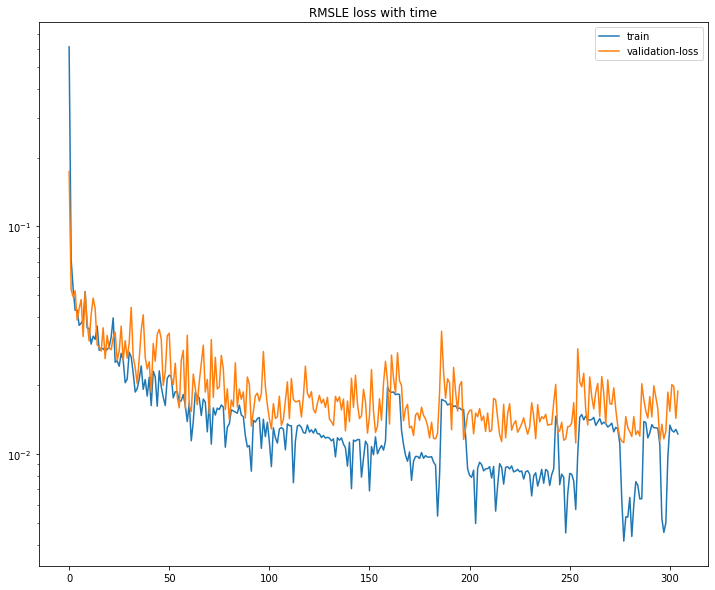

In [116]:
loadModel = 0

if loadModel:
    # load json and create model
    json_file = open('../models/model.json', 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    dp_model = model_from_json(loaded_model_json)
    # load weights into new model
    dp_model.load_weights("../models/model.h5")
    print("Loaded model from disk")
    
else:
    #create model
    dp_model = Sequential()

    #scale data
    df_PCA_one = convertToPCA(train_one, nComponents)
    df_PCA_one = scaleData(df_PCA_one)
    X = df_PCA_one.drop(['SalePrice'], axis = 1)
    y = df_PCA_one.drop(df_PCA_one.columns.difference(['SalePrice']), axis = 1)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


    #get number of columns in training data
    n_cols = X_train.shape[1]

    #add model layers
    dp_model.add(Dense(300, activation='relu', input_shape=(n_cols,)))
    dp_model.add(Dense(300, activation='relu'))
    dp_model.add(Dense(300, activation='relu'))
    dp_model.add(Dense(300, activation='relu'))
    dp_model.add(Dense(300, activation='relu'))

    dp_model.add(Dense(1))

    #compile model using mse as a measure of model performance
    #opt=tf.keras.optimizers.Adadelta(learning_rate=0.1, rho=0.01, epsilon=1e-07)

    dp_model.compile(optimizer='adam', loss=rmsle_K)

    # #set early stopping monitor so the model stops training when it won't improve anymore
    early_stopping_monitor = EarlyStopping(min_delta=0.01,patience=250)

    #train model
    dp_model.fit(X_train, y_train, validation_split=0.3, epochs=2000, callbacks=[early_stopping_monitor])


    # serialize model to JSON
    model_json = dp_model.to_json()
    with open("../models/model.json", "w") as json_file:
        json_file.write(model_json)
    # serialize weights to HDF5
    dp_model.save_weights("../models/model.h5")
    print("Saved model to disk")

dp_pred = dp_model.predict(X_test)
print('RMSLE score of {:.5f}'. format(rmsle(y_test,dp_pred.ravel())))

plt.figure(figsize=(12,10))
plt.plot(dp_model.history.history['loss'], label='train')
plt.plot(dp_model.history.history['val_loss'], label='validation-loss')
plt.legend()
plt.yscale('log')
plt.title('RMSLE loss with time');

- **RMSLE = 0.01332! <br>Definitely the best score!? Almost too good it seems!**

### ------------------------------------------------------   FINAL SUMMARY   -------------------------------------------------------------------------

#### Best Models:
***LightGBM*** *(numerical dataset)* without scaling: **0.122** <br>
***LightGBM*** *(numerical dataset)* with scaling: **0.122** <br>
***Gradient Boosting Regressor*** *(numerical dataset)* without scaling **0.124** <br>
***Gradient Boosting Regressor*** *(numerical dataset)* with scaling **0.125** <br>
<br>
***LightGBM*** *(binary dataset)* without scaling: **0.122** <br>
***LightGBM*** *(binary dataset)* with scaling: **0.122** <br>
***Gradient Boosting Regressor*** *(binary dataset)* without scaling **0.124** <br>
***Gradient Boosting Regressor*** *(binary dataset)* without scaling **0.124** <br>
***Linear Regression*** with 27-component PCA *(binary dataset)* and scaling **0.129** <br>
***Lasso Regression*** with 27-component PCA *(binary dataset)* and scaling **0.129** <br>
***Ridge Regression*** with 27-component PCA *(binary dataset)* and scaling **0.129** <br>
<br>
***Linear Regression*** with 65-component PCA *(one-hot dataset)* and scaling **0.126** <br>
***Lasso Regression*** with 65-component PCA *(one-hot dataset)* and scaling **0.126** <br>
***Ridge Regression*** with 65-component PCA *(one-hot dataset)* and scaling **0.126** <br>
<br>

***Neural Network*** with 65-component PCA *(one-hot dataset)* and scaling **0.01332** <br>
<br>
**Overall the deep learning model outperforms the rest with an RMSLE of 0.01332**